In [35]:
import pandas as pd
import numpy as np
from benchmarks import *
import glob
import os, sys
import seaborn as sns
import matplotlib.pyplot as plt
import re
import time
from tqdm.notebook import tqdm

In [36]:
MACHINE = 'lassen' if 'lassen' in ROOT_DIR else 'ruby'
print(MACHINE, ROOT_DIR)
prognames = list(progs.keys())
probsizes = ['smlprob', 'medprob', 'lrgprob']

logsDir = ROOT_DIR+'/logs'

goMethods=['cma', 'pso', 'bo']
seeds = [1337, 3827, 9999, 4873]

hypers = {
	'cma':['popsize', 'sigma', 'seed'],
	'pso':['popsize', 'w', 'c1', 'c2', 'seed'],
	#'bo':['utilFnct', ['kappa', 'kappa_decay', 'kappa_decay_delay'], ['xi']]
	'bo':[['utilFnct', 'seed'], ['kappa', 'seed'], ['xi', 'seed']]
}

ruby /usr/WS2/bolet1/ruby-benchmarks/exploreGlobalOptimizations


In [37]:
def plotOneVariableSweep(df, colToPlot, goMethodText=None, baselineXtimes=None):
	# x-axis = samples
	# y-axis = percent xtime
	# legend = colToPlot
	df = df.copy(deep=True)

	# progname, probsize, and method are all the same
	assert len(list(df['progname'].unique())) == 1
	assert len(list(df['probsize'].unique())) == 3
	assert len(list(df['method'].unique())) == 1

	progname = df.iloc[0]['progname']
	#probsize = df.iloc[0]['probsize']
	method = df.iloc[0]['method']

	if goMethodText:
		method += f' ({goMethodText})'

	# shrink what we're working with
	df = df.drop(['progname', 'method', 'optimXtime'], axis=1)

	print(df.columns)

	# set the beginning xtimes to 0 since they were random samples
	#if method == 'pso' or method == 'cma':
	#	df.loc[df['globalSample'] < df['popsize'], 'xtime'] = 0.0
	#else:
	#	df.loc[df['globalSample'] == 0, 'xtime'] = 0.0

	otherCols = list(df.columns)
	otherCols.remove('xtime')
	otherCols.remove('globalSample')

	# for each category, we need to do a cumulative max
	df['cummax'] = df.groupby(otherCols, dropna=False)['xtime'].transform('cummax')

	g = sns.FacetGrid(df, col='probsize', col_order=probsizes, hue=colToPlot, palette='flare', legend_out=True, height=5, aspect=1.5)
	g.map_dataframe(sns.lineplot, x='globalSample', y='cummax', errorbar="pi")
	g.add_legend()
	g.set(ylim=(-0.05, 1.05))
	g.fig.subplots_adjust(top=0.85)
	g.fig.suptitle(f'{progname} -- {method.upper()} -- sweep "{colToPlot}" hyperparam')

	axes = g.axes.flatten()
	axes[0].set_ylabel('Norm. to Optimal/Worst Execution Times from Database \n(higher is better)')
	for ax in axes:
		ax.set_xlabel('Sample Index')
		ax.axhline(y=1.0, zorder=0, ls='--')
		axTitle = ax.get_title()
		if 'lrgprob' in axTitle:
			ax.set_title('Large Input')
			ax.axhline(y=baselineXtimes['lrgprob'], zorder=0, ls='--', c='red')
		elif 'medprob' in axTitle:
			ax.set_title('Medium Input')
			ax.axhline(y=baselineXtimes['medprob'], zorder=0, ls='--', c='red')
		else:
			ax.set_title('Small Input')
			ax.axhline(y=baselineXtimes['smlprob'], zorder=0, ls='--', c='red')

	plt.show()
	return

In [38]:
dbFile = f'{MACHINE}-fullExploreDataset.csv'
xtimeDB = pd.read_csv(ROOT_DIR+'/databases/'+dbFile)

numthreads = 112 if MACHINE in 'ruby' else 160

def getMinMaxXtimeForProg(progname, probsize):
	df = xtimeDB[(xtimeDB['progname'] == progname) & 
							 (xtimeDB['probsize'] == probsize)]['xtime']
	return (df.min(), df.max())

# 0 will mean close to maxXtime
# 1 will mean close to minXtime
def convertXtimesToPercent(df, minXtime, maxXtime):

	#df['xtime'] = 1 - (df['xtime']-minXtime)/(maxXtime-minXtime)
	df.loc[:,'xtime'] = 1 - (df['xtime']-minXtime)/(maxXtime-minXtime)
	return df

def plotIndividualVariablesForAllCodes():
	baselinesDF = xtimeDB[(xtimeDB['OMP_NUM_THREADS'] == numthreads) 
											& (xtimeDB['OMP_PROC_BIND'] == 'close')
											& (xtimeDB['OMP_PLACES'] == 'threads')
											& (xtimeDB['OMP_SCHEDULE'] == 'static')]
	
	# this plots each of the individual variables of each method
	# applied to each progname+probsize combination.
	# it averages xtimes across seeds.
	for progname in prognames:
		if progname == 'cg_nas':
			continue
		for method in goMethods:
			# read the pre-processed dataframe
			filename = ROOT_DIR+'/databases/'+f'{MACHINE}-{progname}-{method}-GO_Data.csv'
			fullDF = pd.read_csv(filename)
				
			hyps = hypers[method]
			for hyp in hyps:
				baselineXtimes = baselinesDF[(baselinesDF['progname'] == progname)]
				#print('baselineXtimes')
				#print(baselineXtimes)
				for probsize in ['smlprob', 'medprob', 'lrgprob']:
					mintime, maxtime = getMinMaxXtimeForProg(progname, probsize)
					baselineXtimes.loc[baselineXtimes['probsize'] == probsize, 'xtime'] = convertXtimesToPercent(baselineXtimes[baselineXtimes['probsize'] == probsize], mintime, maxtime)

				#print('fulldf', baselineXtimes)
				baseXtimes = pd.Series(baselineXtimes.xtime.values, index=baselineXtimes.probsize).to_dict()
				#print(baseXtimes)
				
				if method == 'bo':
					if 'kappa' in hyp:
						boDF = fullDF[fullDF['utilFnct'] == 'ucb']
						for h in hyp:
							plotOneVariableSweep(boDF, h, 'ucb', baseXtimes)
					elif 'xi' in hyp:
						boDF = fullDF[fullDF['utilFnct'] == 'poi']
						for h in hyp:
							plotOneVariableSweep(boDF, h, 'poi', baseXtimes)
						boDF = fullDF[fullDF['utilFnct'] == 'ei']
						for h in hyp:
							plotOneVariableSweep(boDF, h, 'ei', baseXtimes)
					else:
						for h in hyp:
							plotOneVariableSweep(fullDF, h, 'overall', baseXtimes)
				else:
					plotOneVariableSweep(fullDF, hyp, None, baseXtimes)
				#return
	return
				



Index(['probsize', 'seed', 'globalSample', 'xtime', 'sigma', 'popsize'], dtype='object')


Index(['probsize', 'seed', 'globalSample', 'xtime', 'sigma', 'popsize'], dtype='object')


Index(['probsize', 'seed', 'globalSample', 'xtime', 'sigma', 'popsize'], dtype='object')


Index(['probsize', 'seed', 'globalSample', 'xtime', 'popsize', 'w', 'c1',
       'c2'],
      dtype='object')


Index(['probsize', 'seed', 'globalSample', 'xtime', 'popsize', 'w', 'c1',
       'c2'],
      dtype='object')


Index(['probsize', 'seed', 'globalSample', 'xtime', 'popsize', 'w', 'c1',
       'c2'],
      dtype='object')


Index(['probsize', 'seed', 'globalSample', 'xtime', 'popsize', 'w', 'c1',
       'c2'],
      dtype='object')


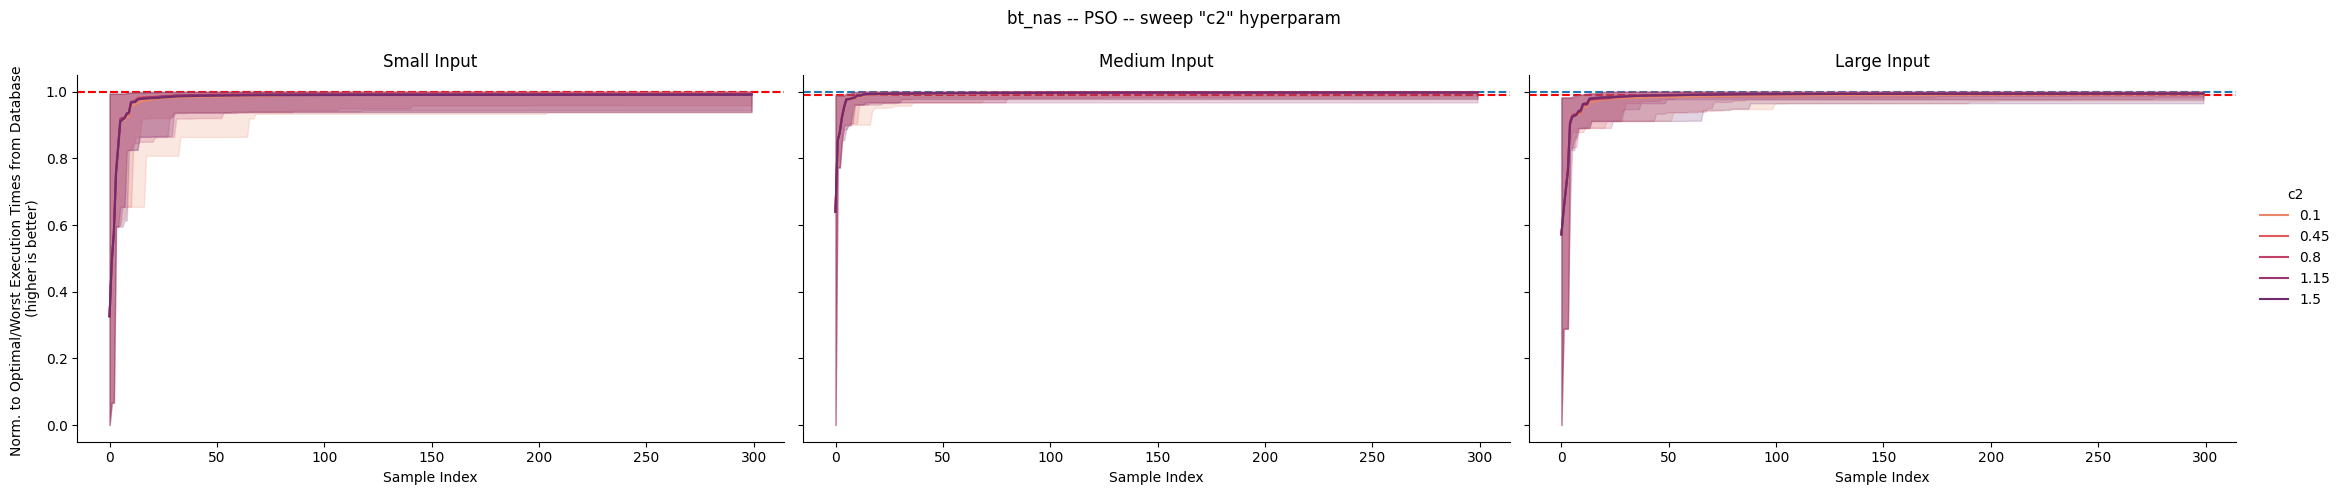

Index(['probsize', 'seed', 'globalSample', 'xtime', 'popsize', 'w', 'c1',
       'c2'],
      dtype='object')


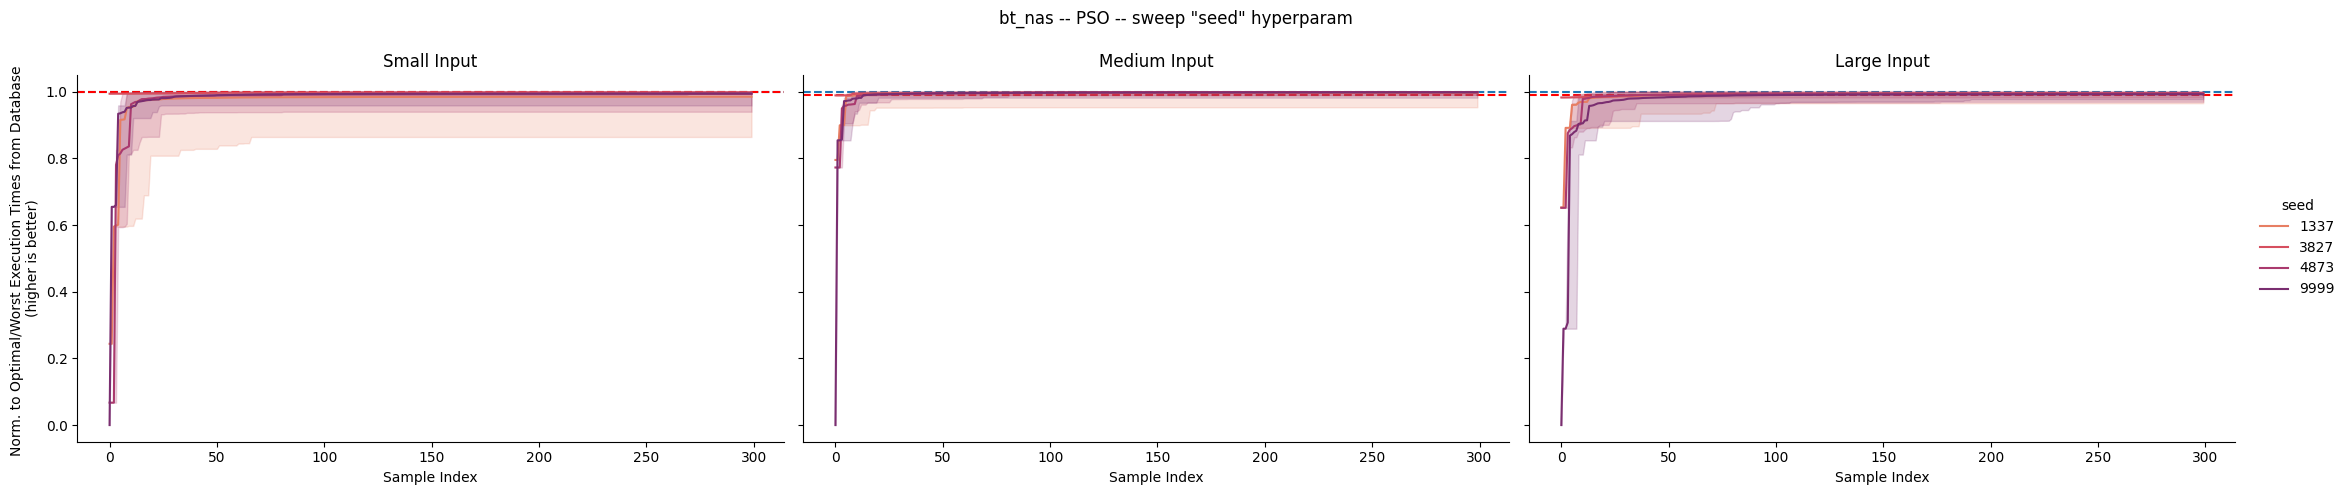

Index(['probsize', 'seed', 'globalSample', 'xtime', 'utilFnct', 'xi', 'kappa',
       'kappa_decay', 'kappa_decay_delay'],
      dtype='object')


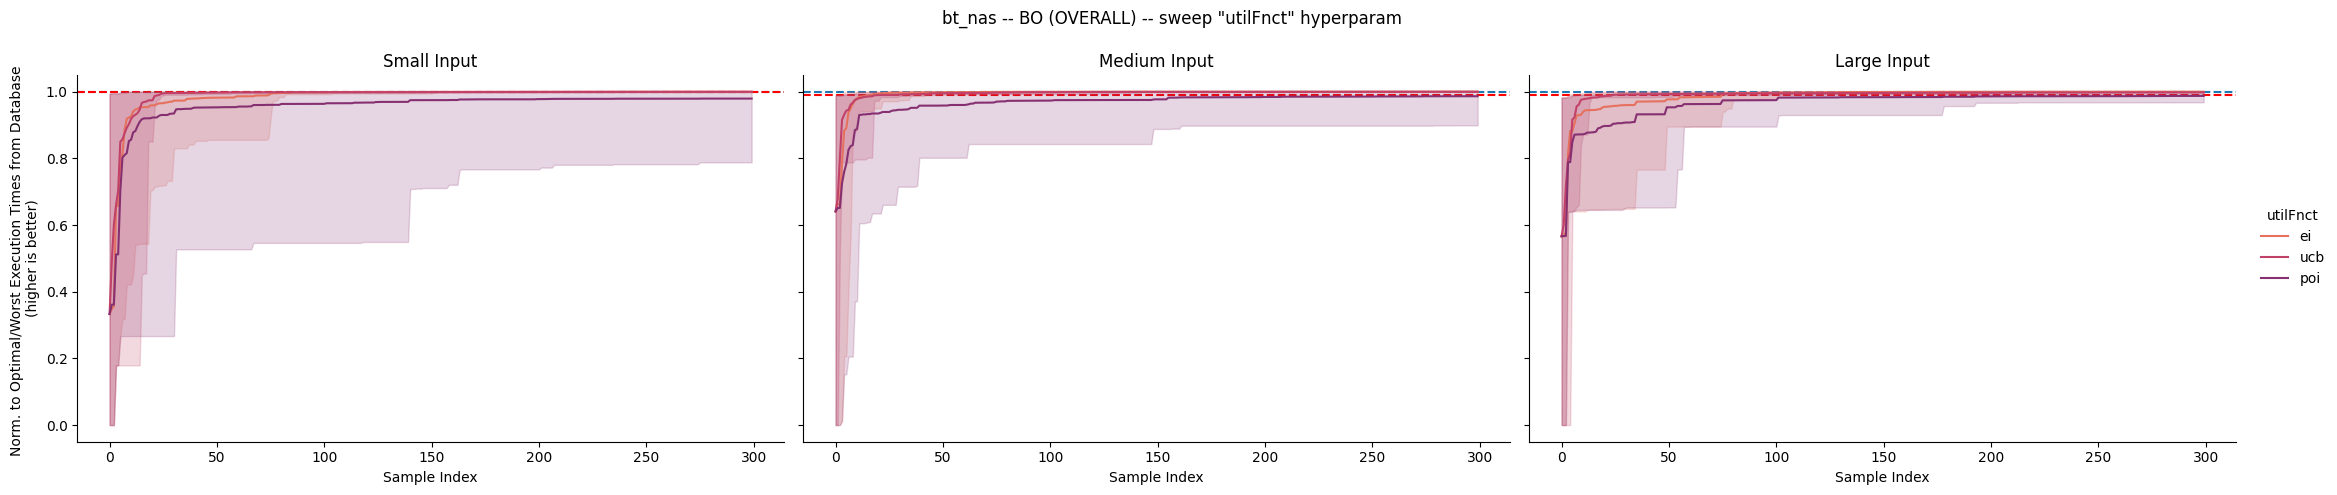

Index(['probsize', 'seed', 'globalSample', 'xtime', 'utilFnct', 'xi', 'kappa',
       'kappa_decay', 'kappa_decay_delay'],
      dtype='object')


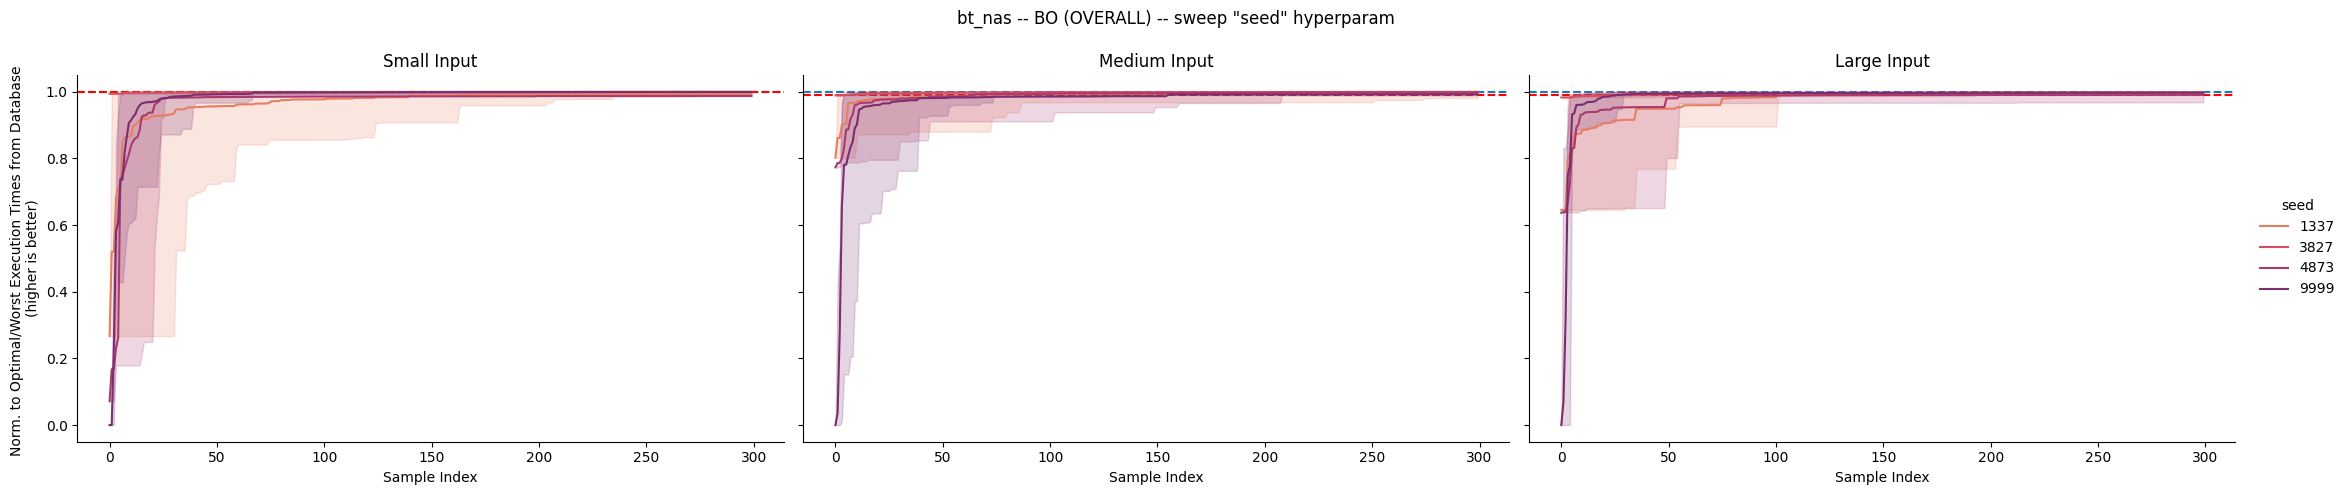

Index(['probsize', 'seed', 'globalSample', 'xtime', 'utilFnct', 'xi', 'kappa',
       'kappa_decay', 'kappa_decay_delay'],
      dtype='object')


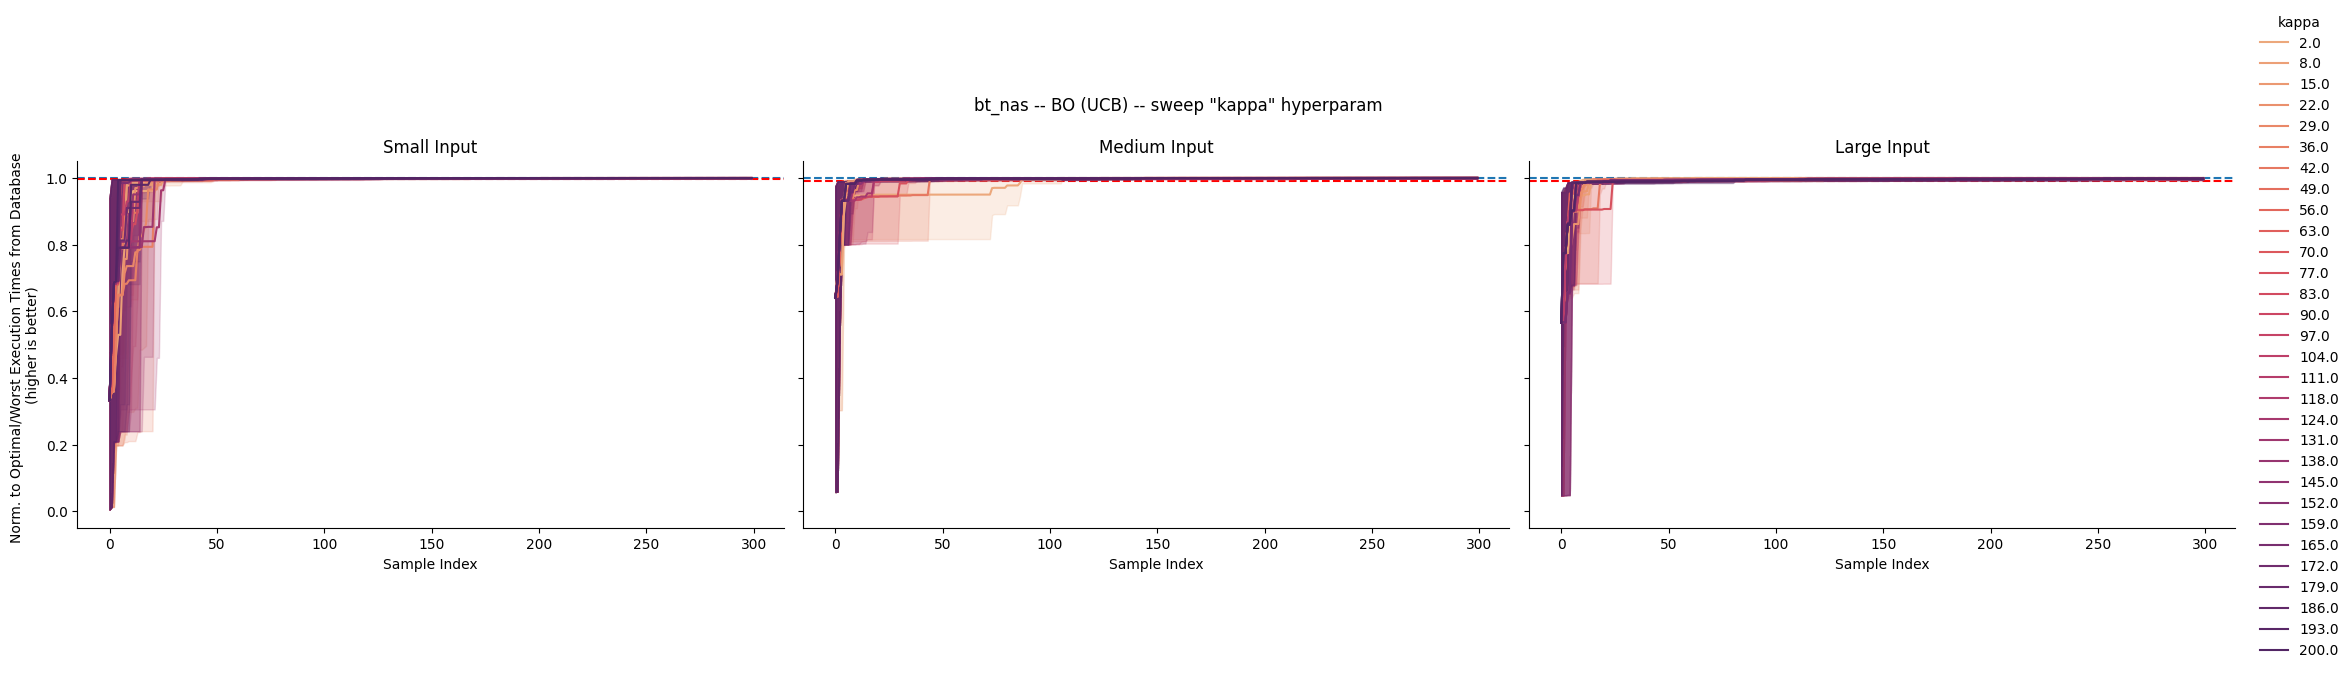

Index(['probsize', 'seed', 'globalSample', 'xtime', 'utilFnct', 'xi', 'kappa',
       'kappa_decay', 'kappa_decay_delay'],
      dtype='object')


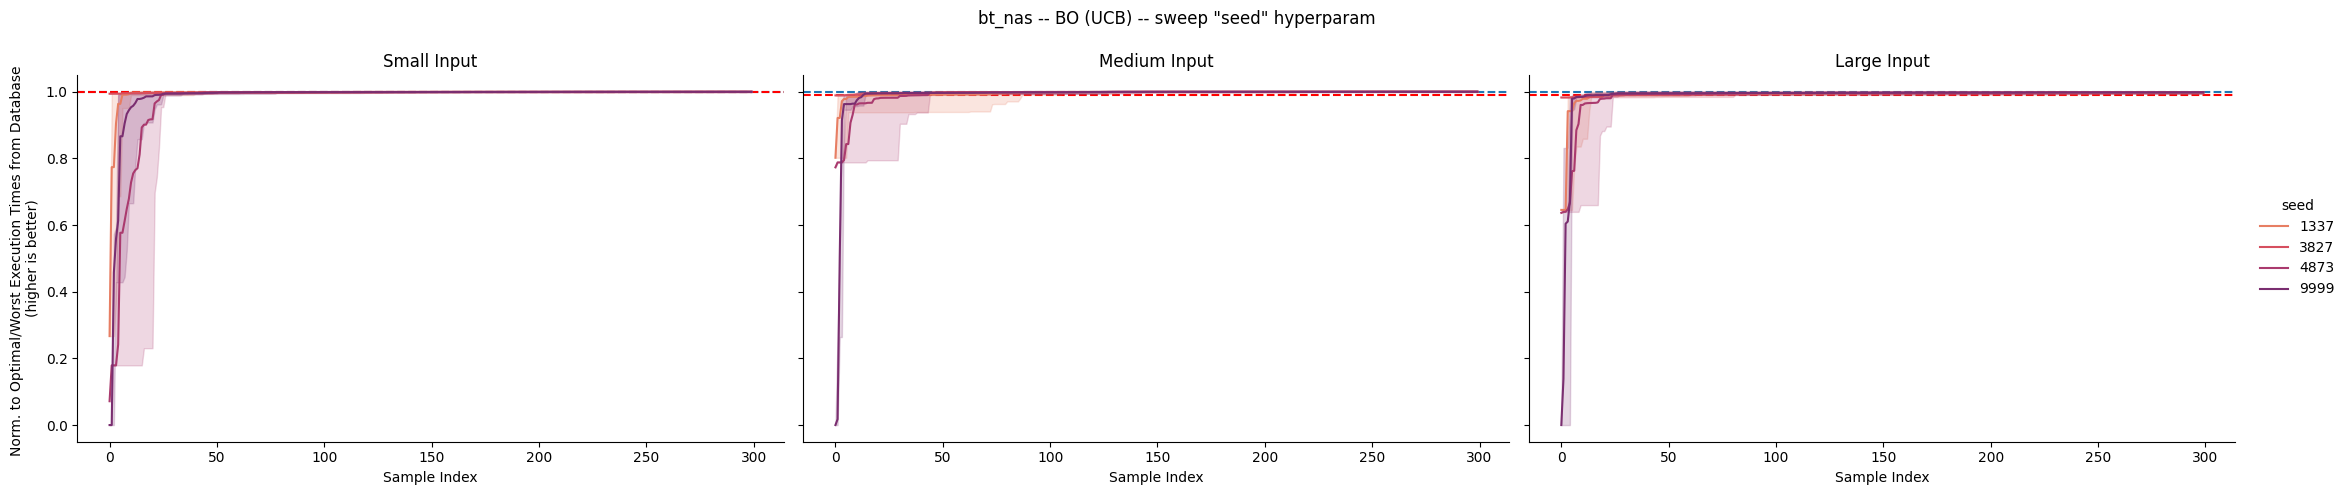

Index(['probsize', 'seed', 'globalSample', 'xtime', 'utilFnct', 'xi', 'kappa',
       'kappa_decay', 'kappa_decay_delay'],
      dtype='object')


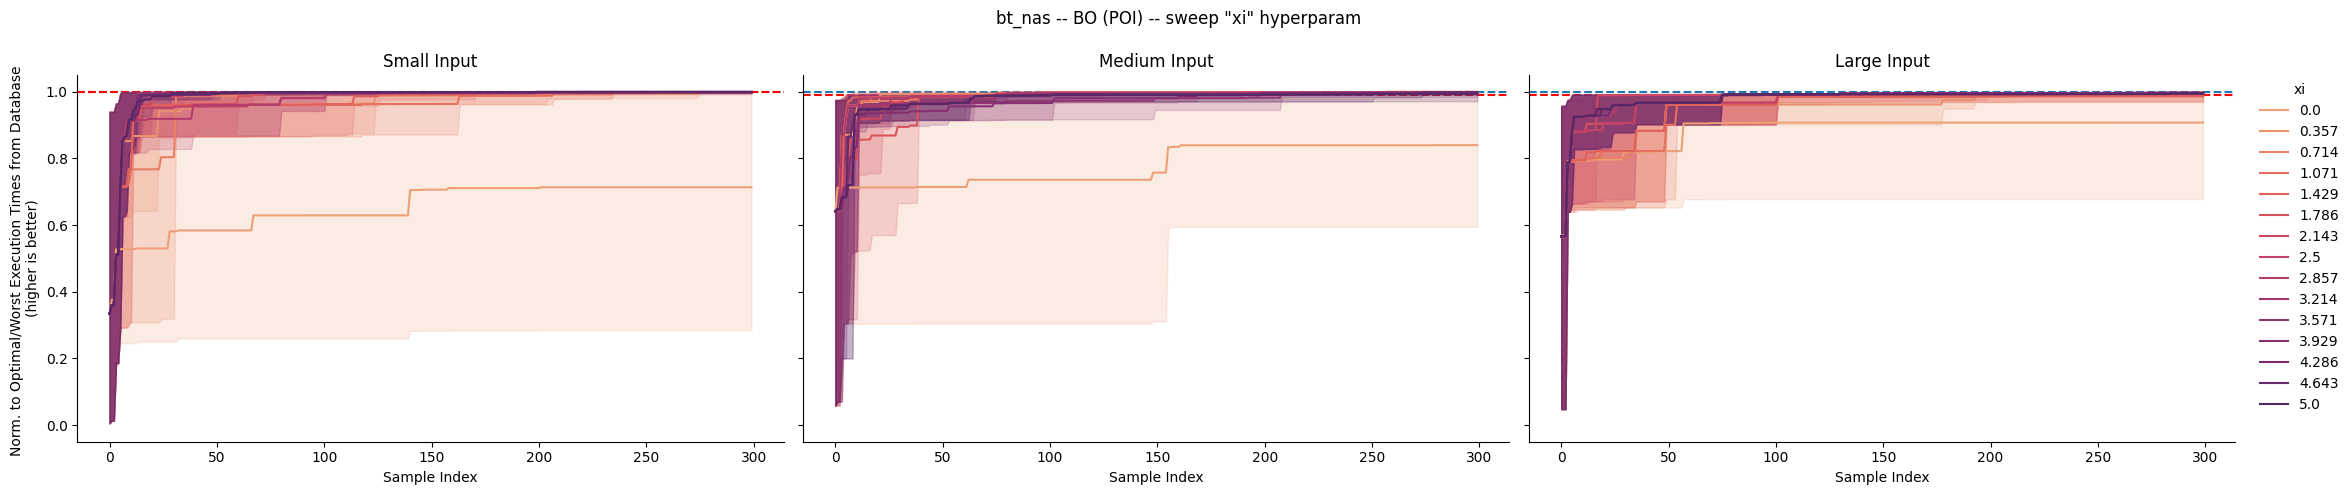

Index(['probsize', 'seed', 'globalSample', 'xtime', 'utilFnct', 'xi', 'kappa',
       'kappa_decay', 'kappa_decay_delay'],
      dtype='object')


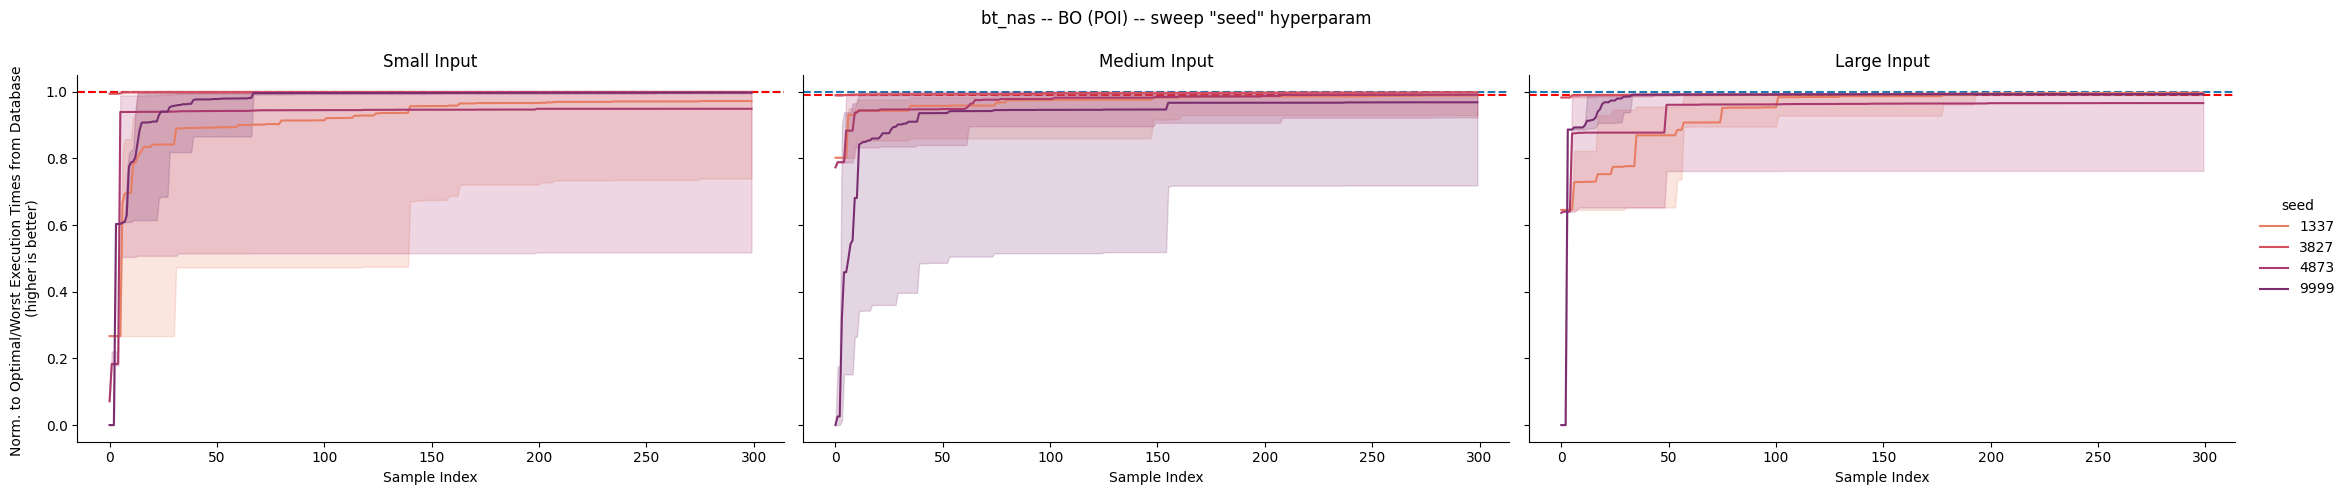

Index(['probsize', 'seed', 'globalSample', 'xtime', 'utilFnct', 'xi', 'kappa',
       'kappa_decay', 'kappa_decay_delay'],
      dtype='object')


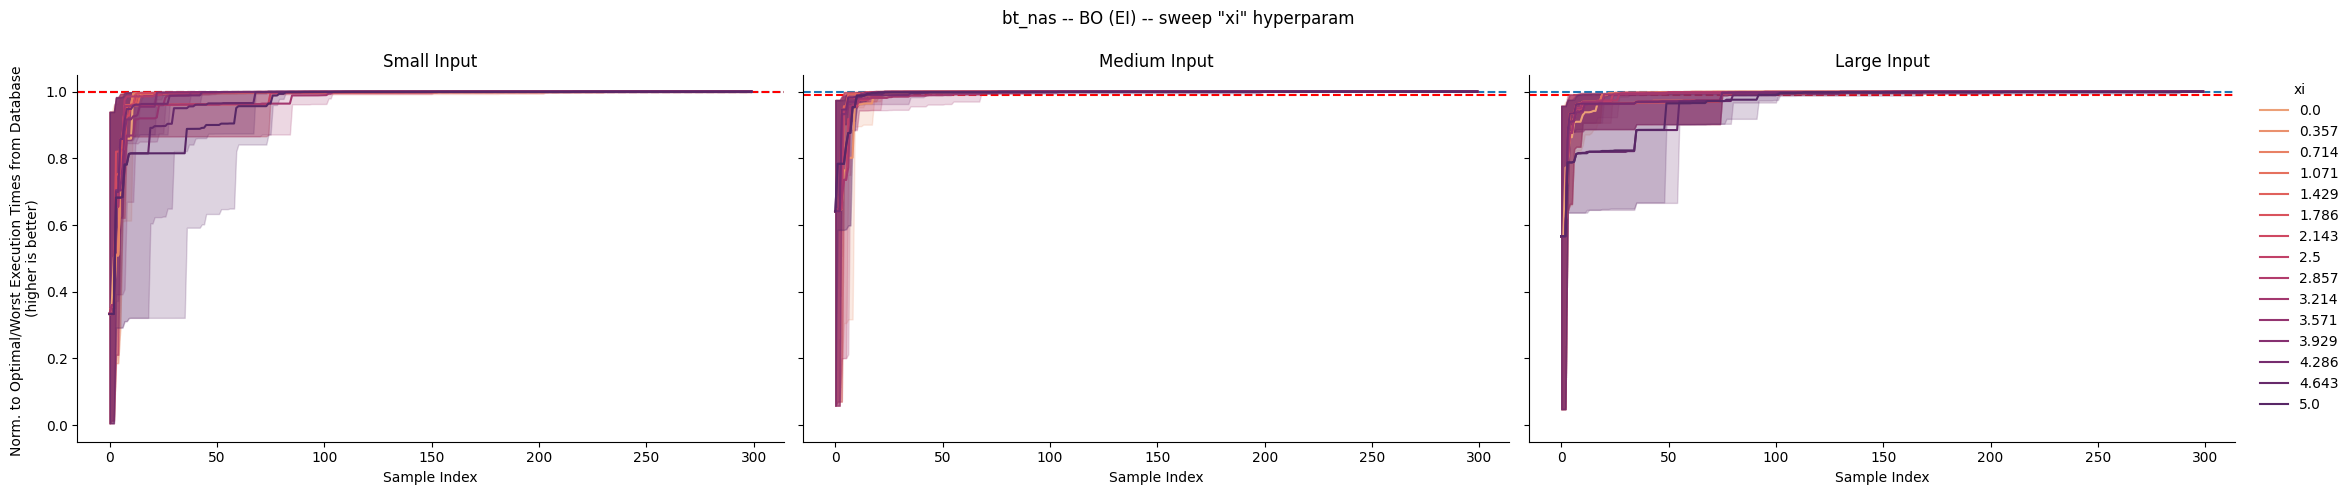

Index(['probsize', 'seed', 'globalSample', 'xtime', 'utilFnct', 'xi', 'kappa',
       'kappa_decay', 'kappa_decay_delay'],
      dtype='object')


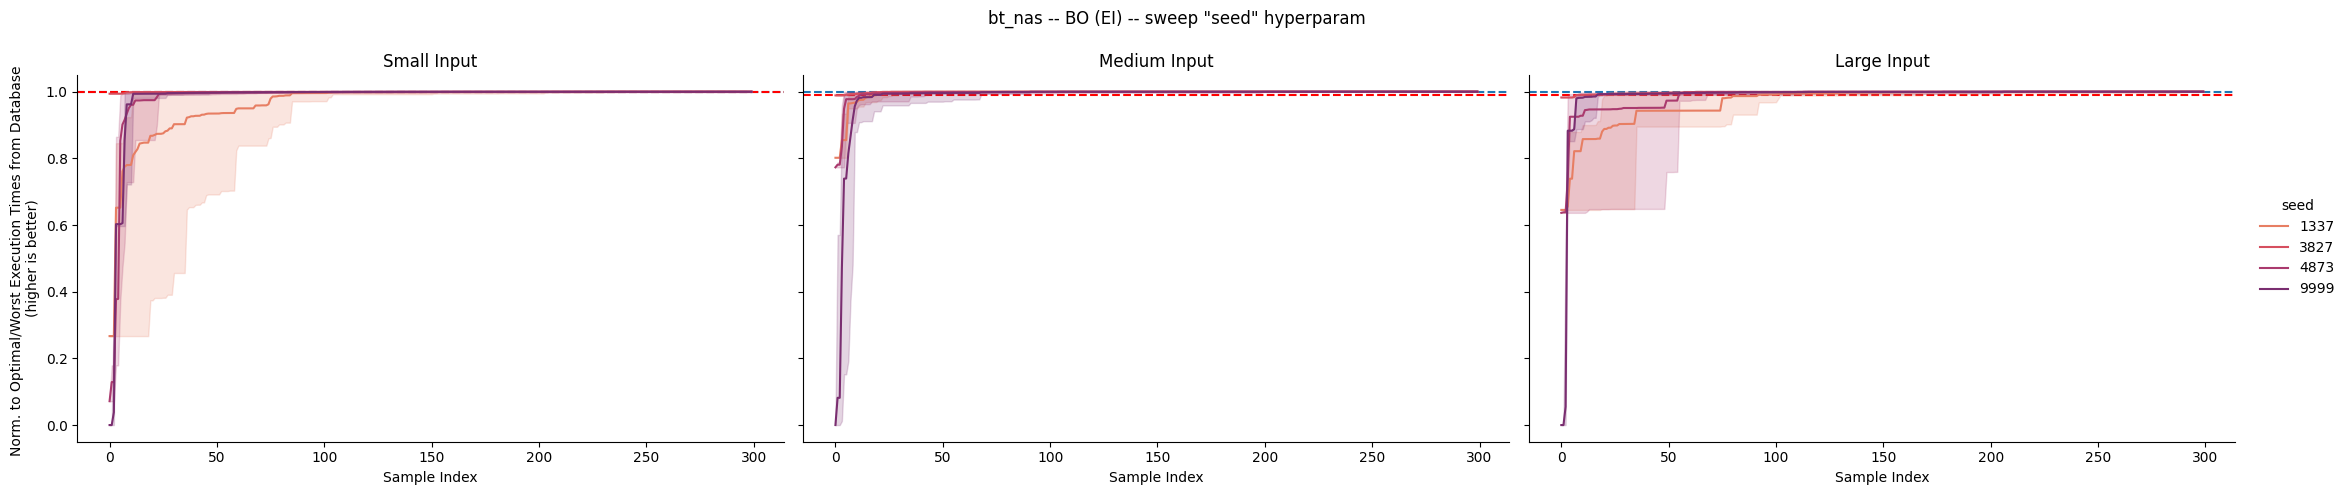

Index(['probsize', 'seed', 'globalSample', 'xtime', 'sigma', 'popsize'], dtype='object')


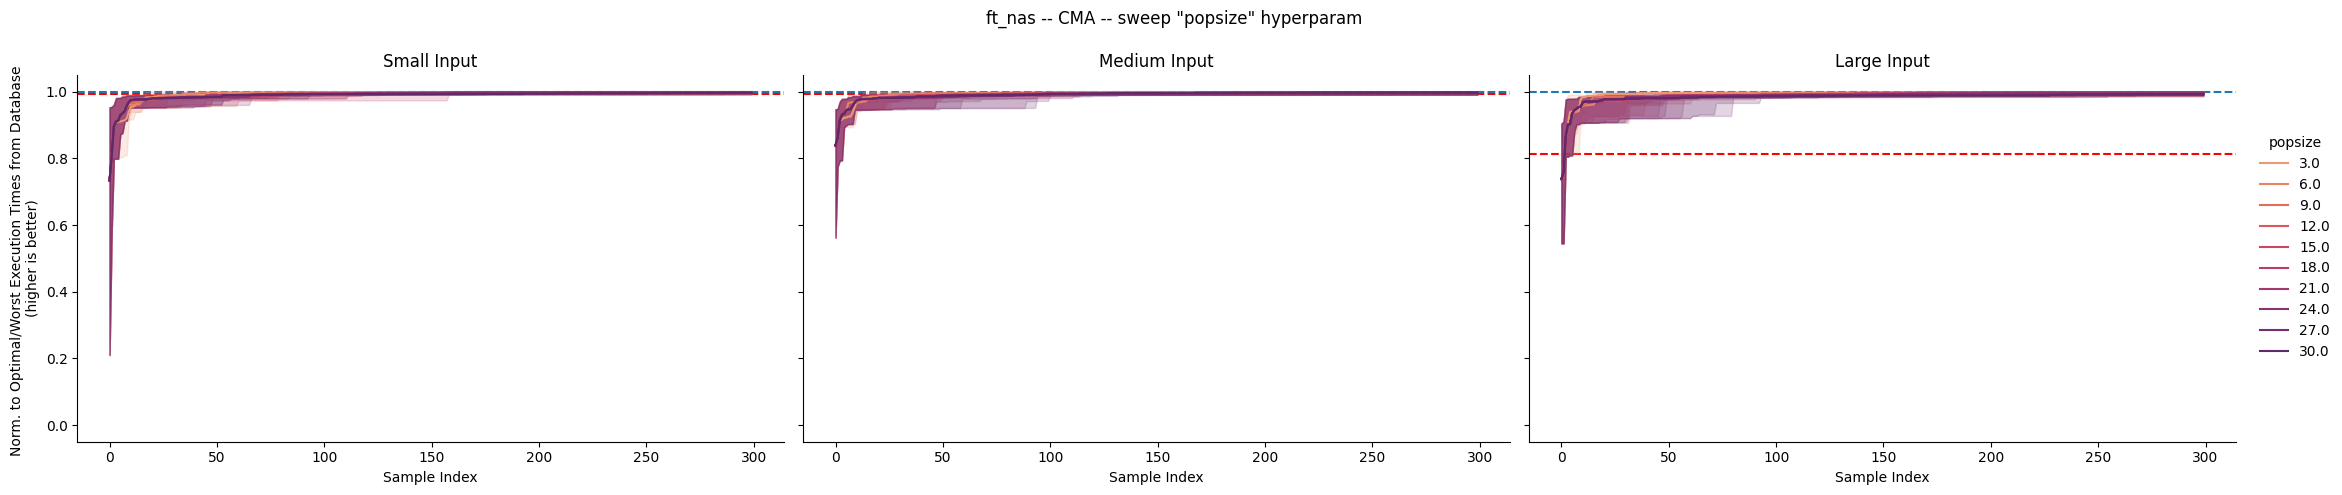

Index(['probsize', 'seed', 'globalSample', 'xtime', 'sigma', 'popsize'], dtype='object')


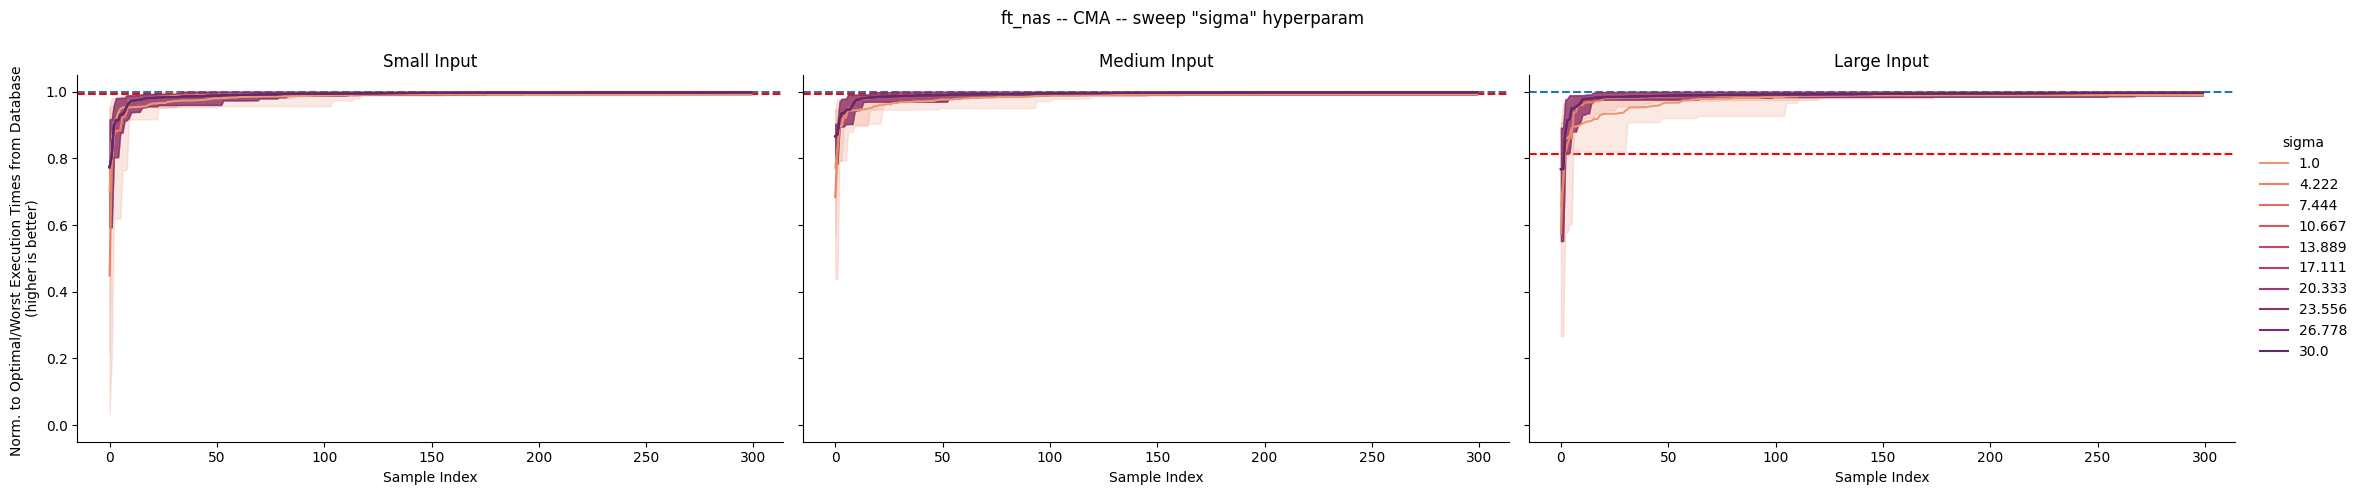

Index(['probsize', 'seed', 'globalSample', 'xtime', 'sigma', 'popsize'], dtype='object')


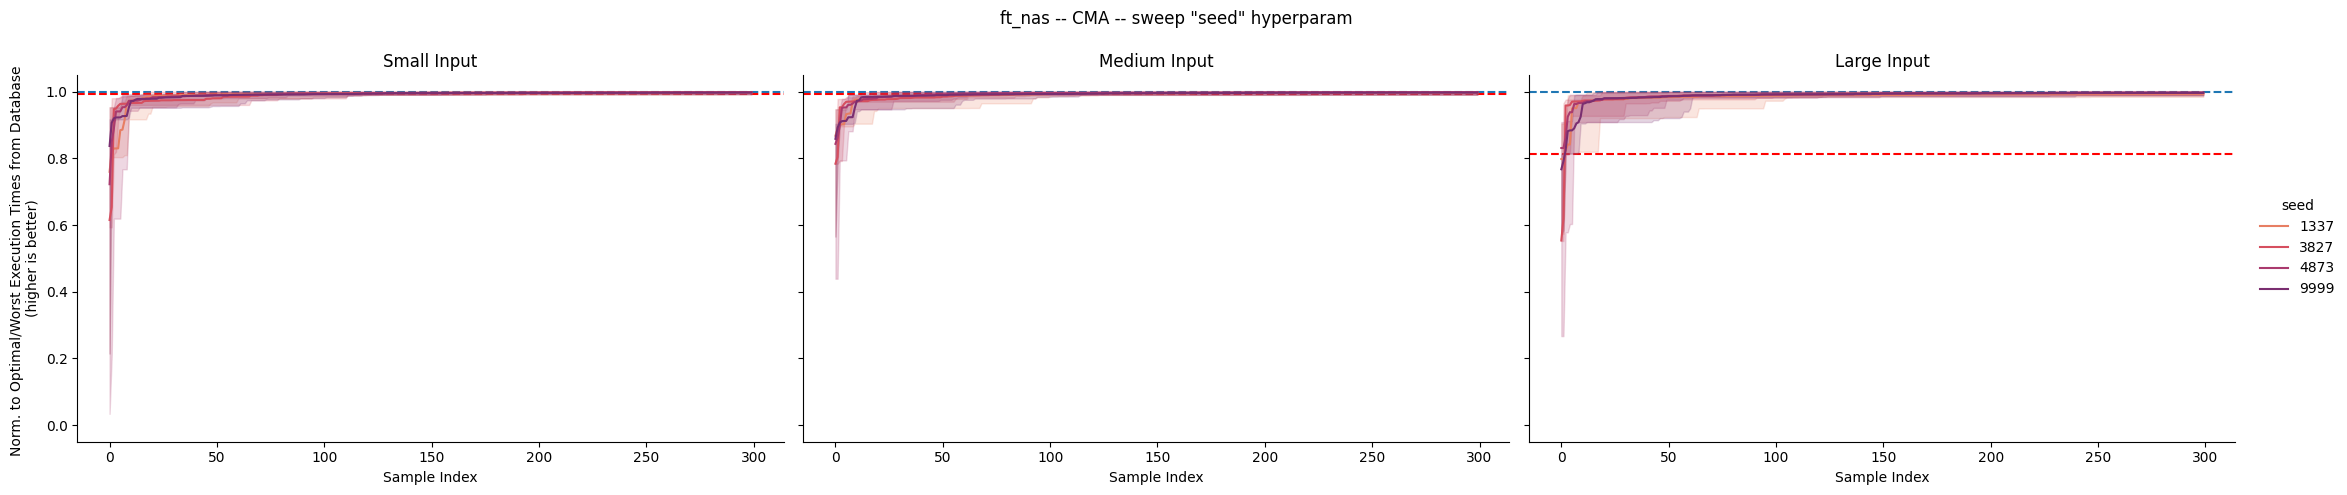

Index(['probsize', 'seed', 'globalSample', 'xtime', 'popsize', 'w', 'c1',
       'c2'],
      dtype='object')


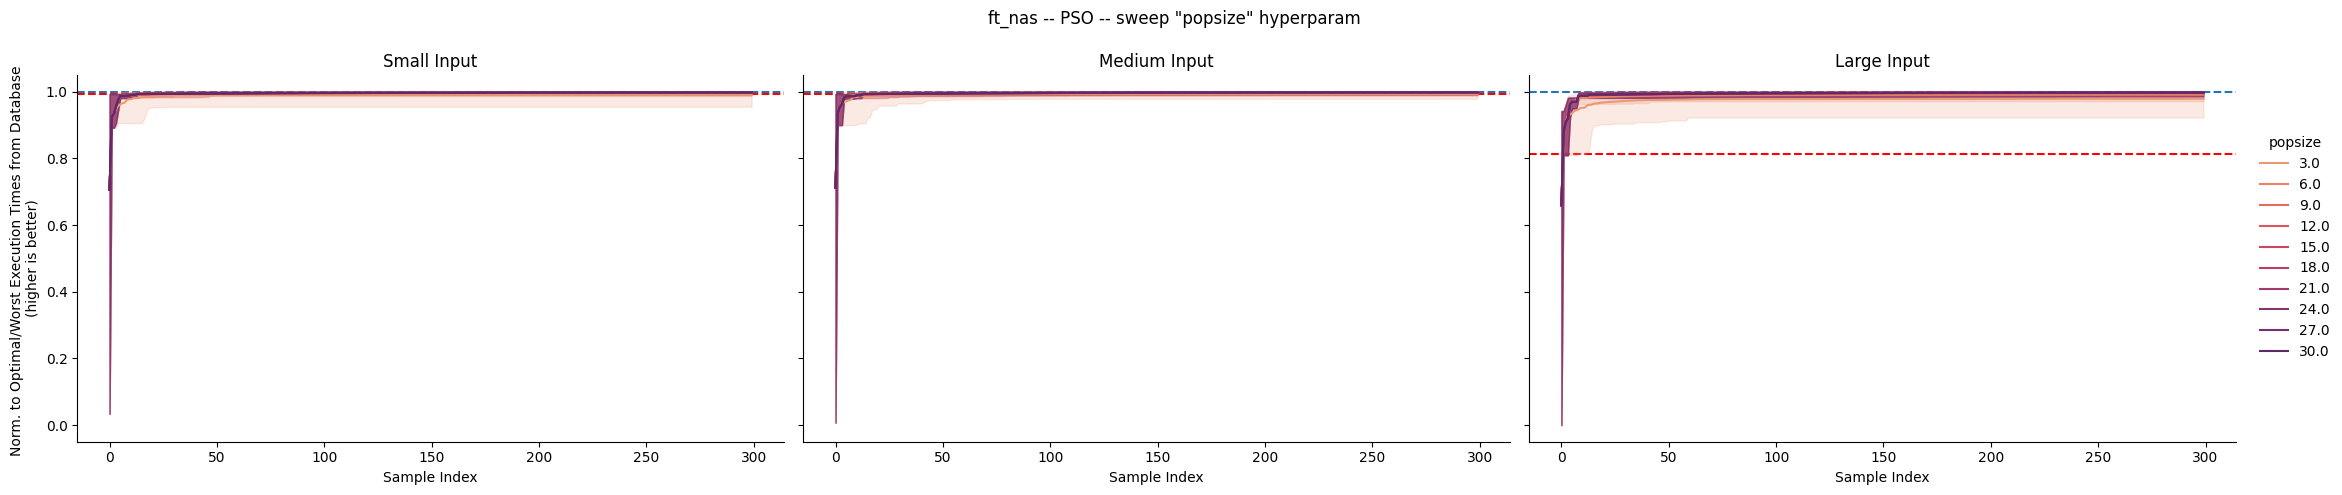

Index(['probsize', 'seed', 'globalSample', 'xtime', 'popsize', 'w', 'c1',
       'c2'],
      dtype='object')


Index(['probsize', 'seed', 'globalSample', 'xtime', 'popsize', 'w', 'c1',
       'c2'],
      dtype='object')


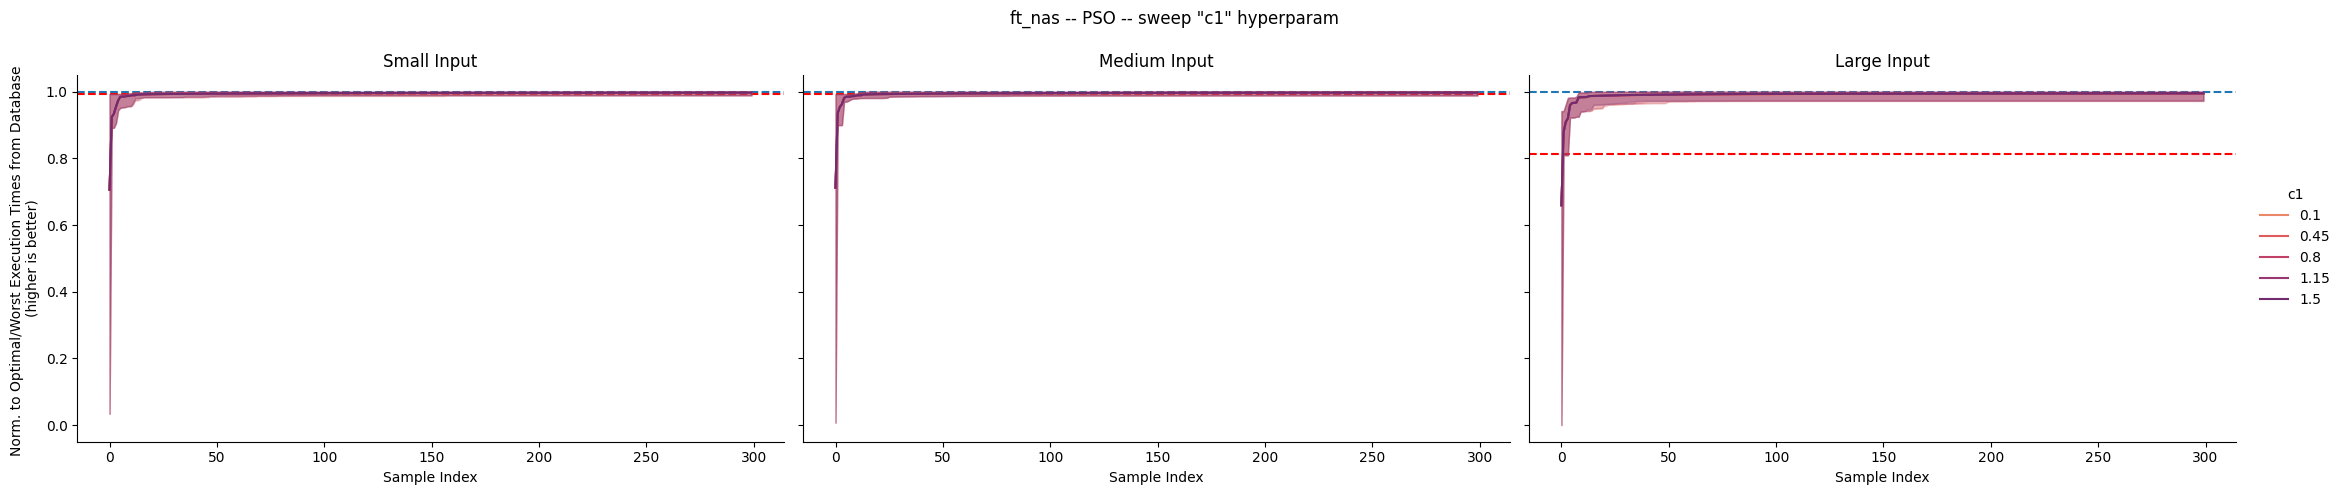

Index(['probsize', 'seed', 'globalSample', 'xtime', 'popsize', 'w', 'c1',
       'c2'],
      dtype='object')


Index(['probsize', 'seed', 'globalSample', 'xtime', 'popsize', 'w', 'c1',
       'c2'],
      dtype='object')


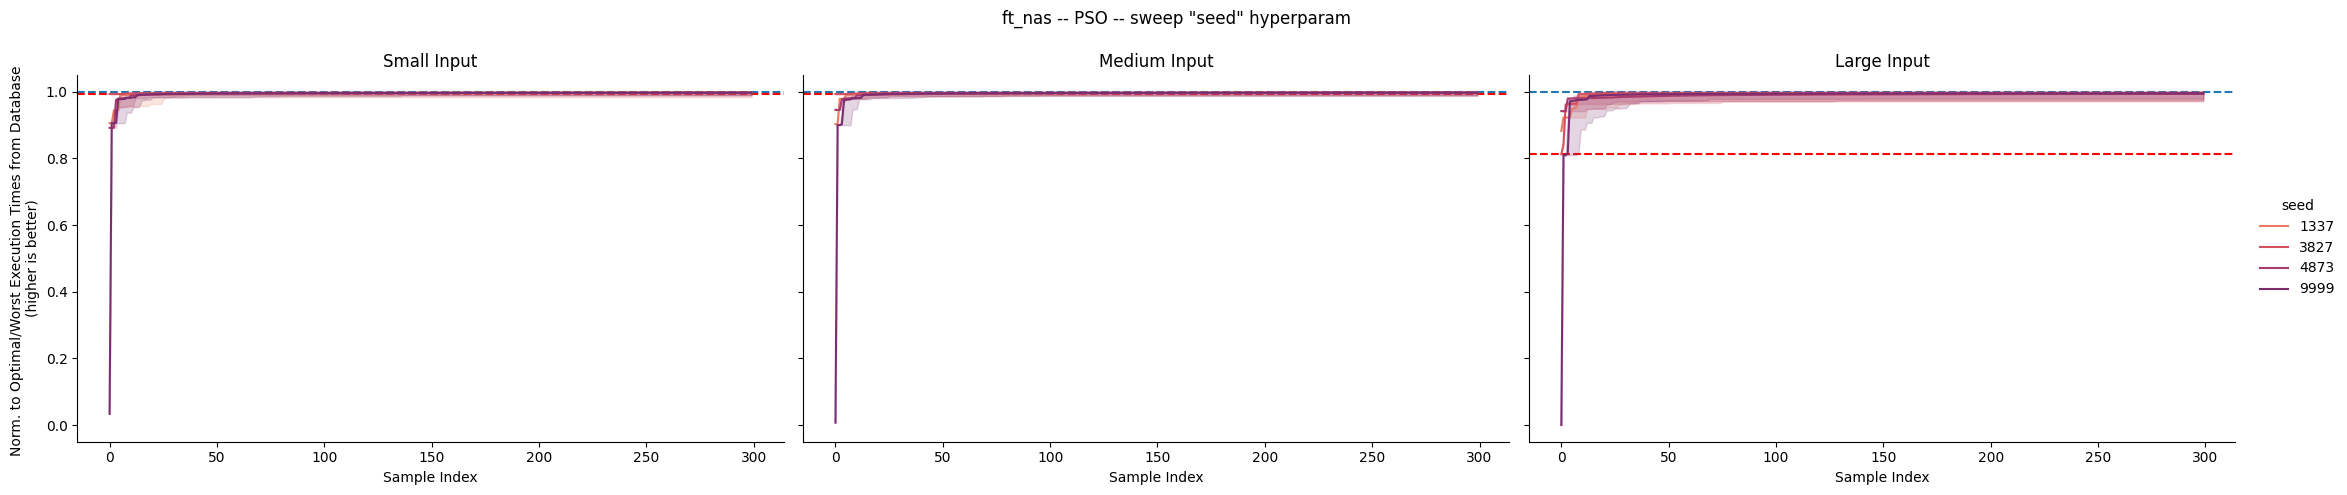

Index(['probsize', 'seed', 'globalSample', 'xtime', 'utilFnct', 'xi', 'kappa',
       'kappa_decay', 'kappa_decay_delay'],
      dtype='object')


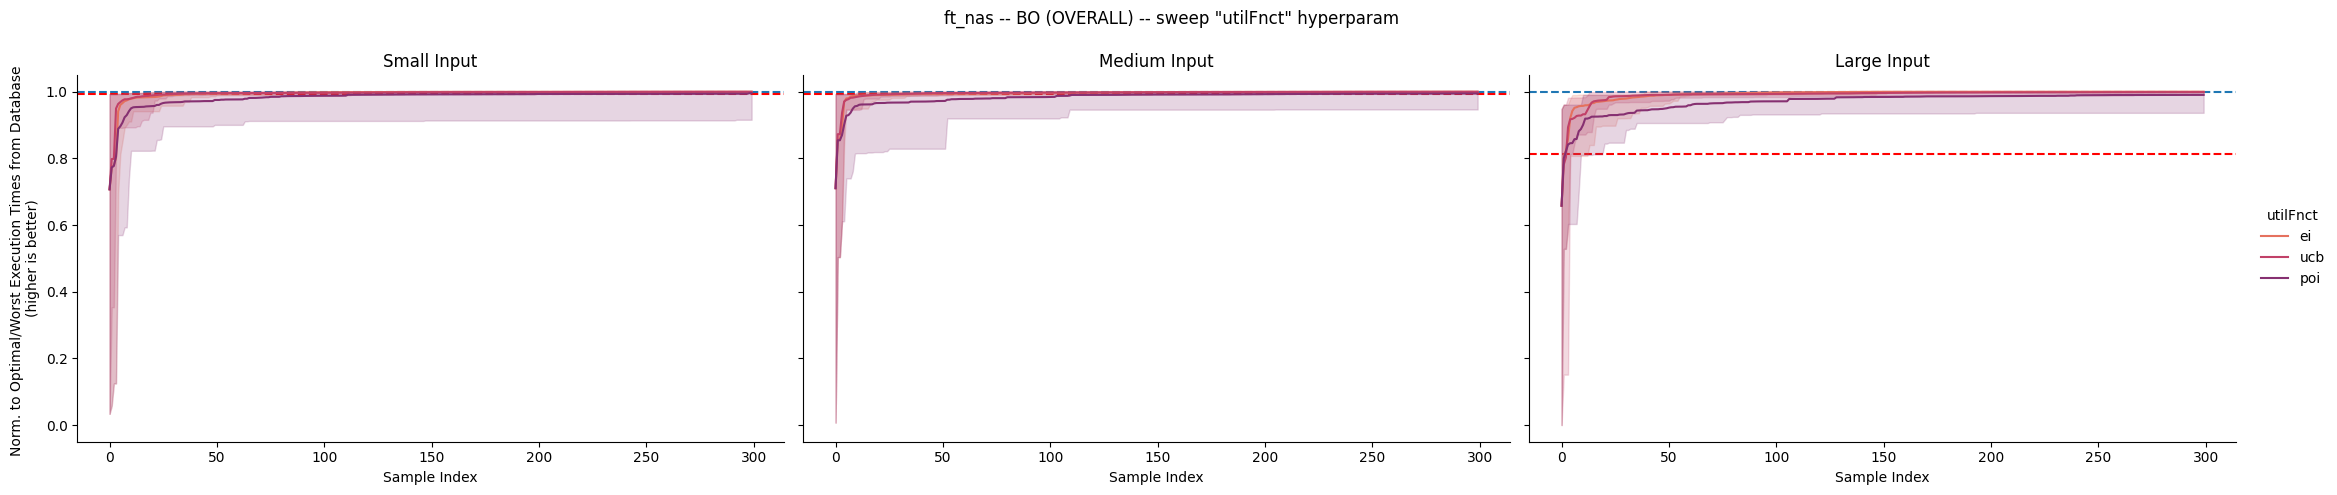

Index(['probsize', 'seed', 'globalSample', 'xtime', 'utilFnct', 'xi', 'kappa',
       'kappa_decay', 'kappa_decay_delay'],
      dtype='object')


Index(['probsize', 'seed', 'globalSample', 'xtime', 'utilFnct', 'xi', 'kappa',
       'kappa_decay', 'kappa_decay_delay'],
      dtype='object')


Index(['probsize', 'seed', 'globalSample', 'xtime', 'utilFnct', 'xi', 'kappa',
       'kappa_decay', 'kappa_decay_delay'],
      dtype='object')


Index(['probsize', 'seed', 'globalSample', 'xtime', 'utilFnct', 'xi', 'kappa',
       'kappa_decay', 'kappa_decay_delay'],
      dtype='object')


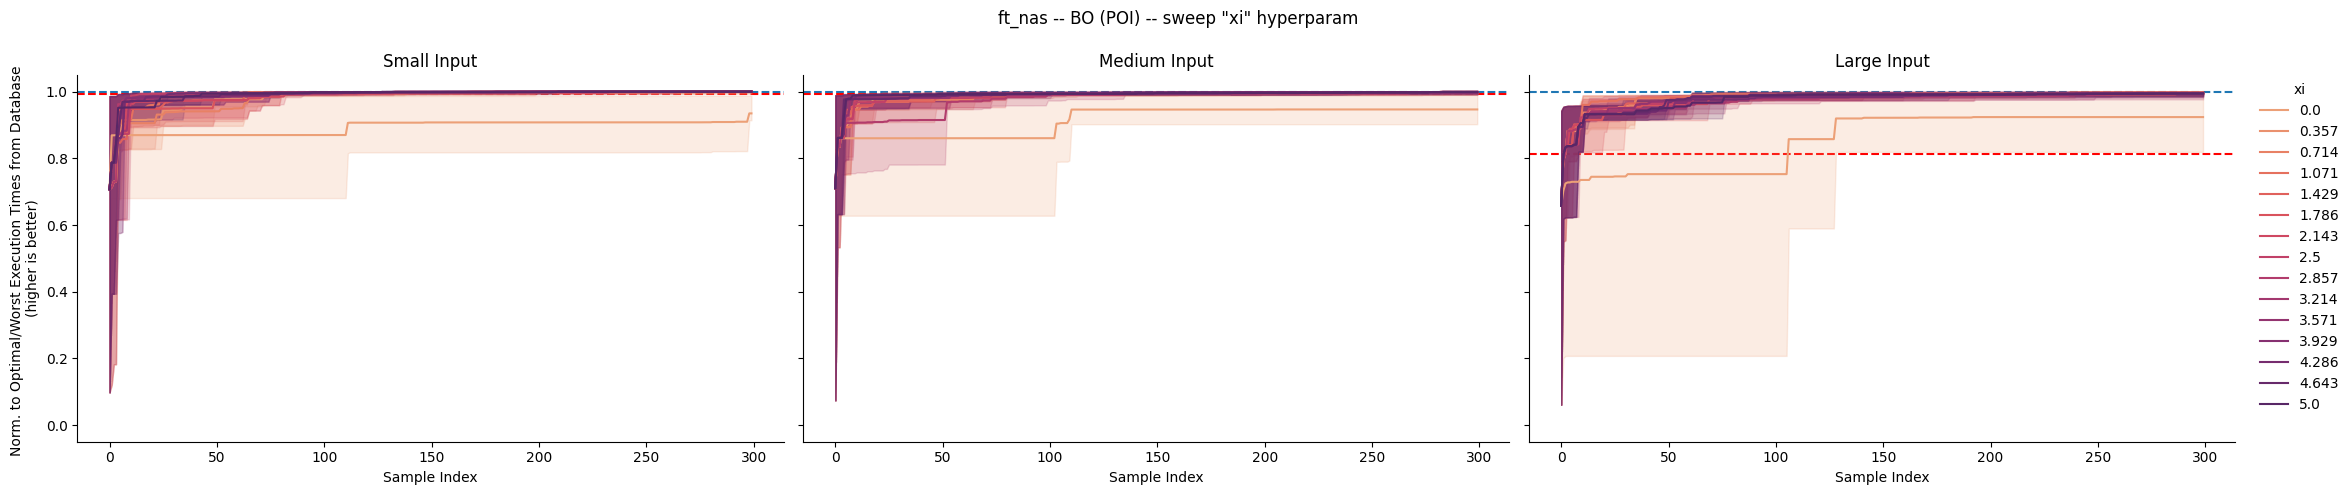

Index(['probsize', 'seed', 'globalSample', 'xtime', 'utilFnct', 'xi', 'kappa',
       'kappa_decay', 'kappa_decay_delay'],
      dtype='object')


Index(['probsize', 'seed', 'globalSample', 'xtime', 'utilFnct', 'xi', 'kappa',
       'kappa_decay', 'kappa_decay_delay'],
      dtype='object')


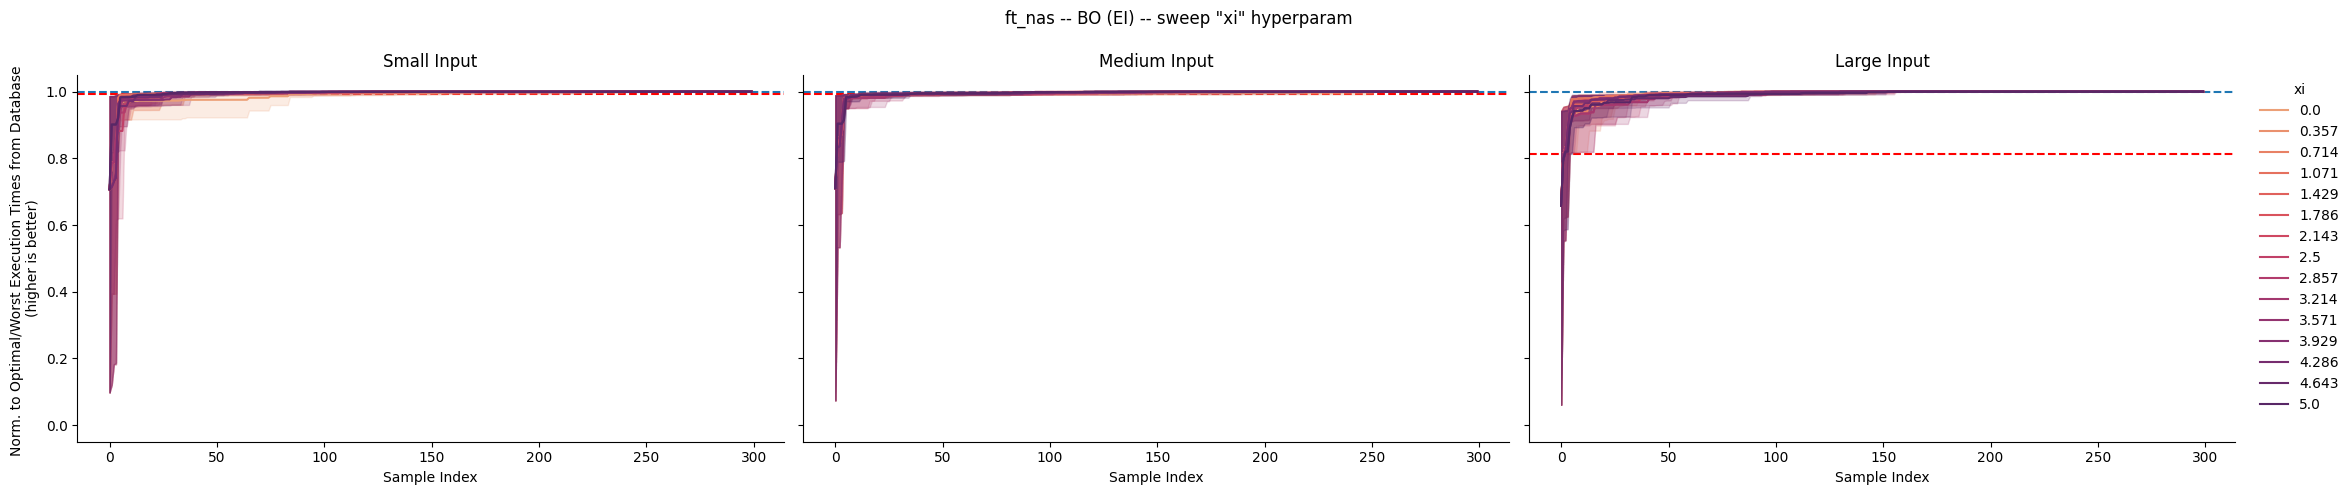

Index(['probsize', 'seed', 'globalSample', 'xtime', 'utilFnct', 'xi', 'kappa',
       'kappa_decay', 'kappa_decay_delay'],
      dtype='object')


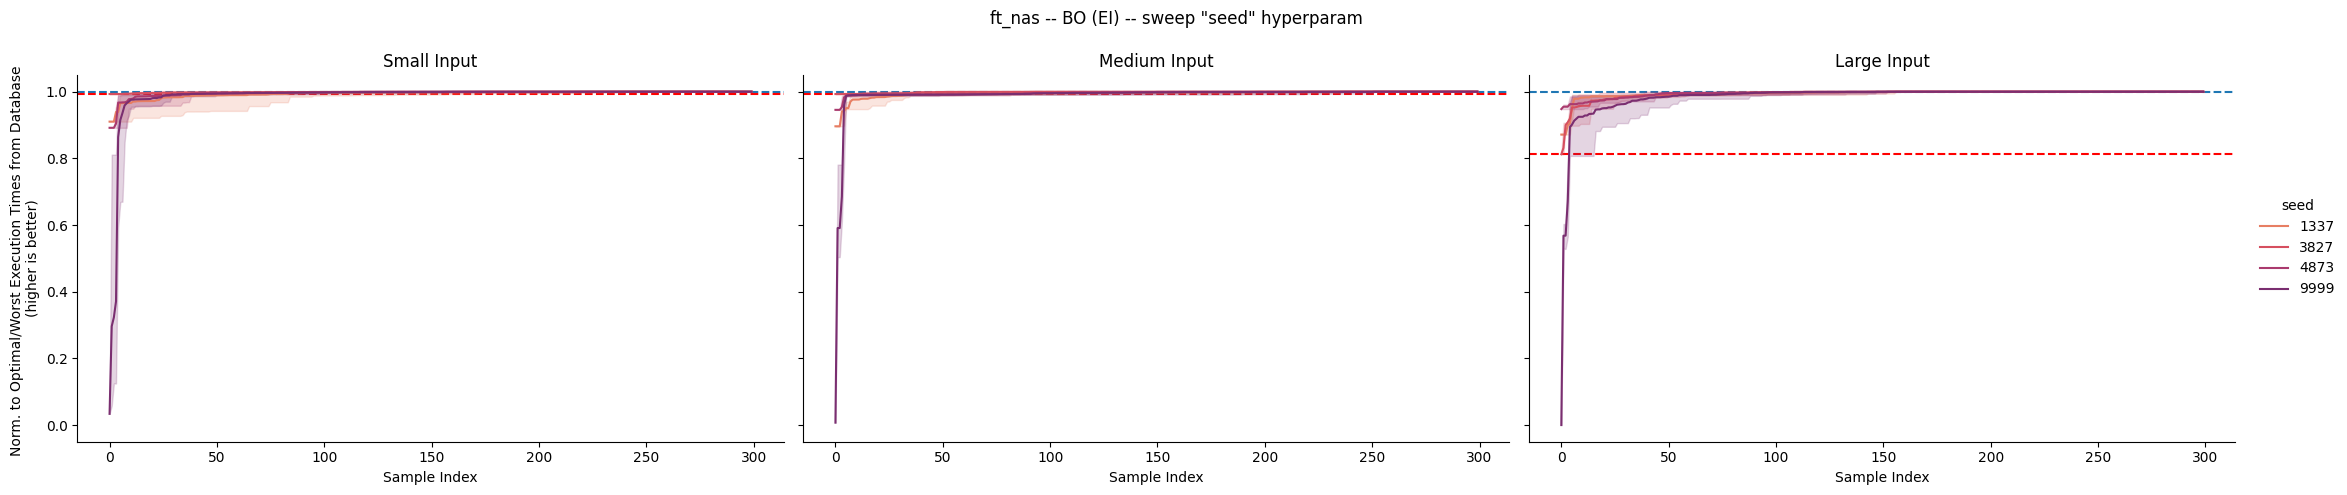

Index(['probsize', 'seed', 'globalSample', 'xtime', 'sigma', 'popsize'], dtype='object')


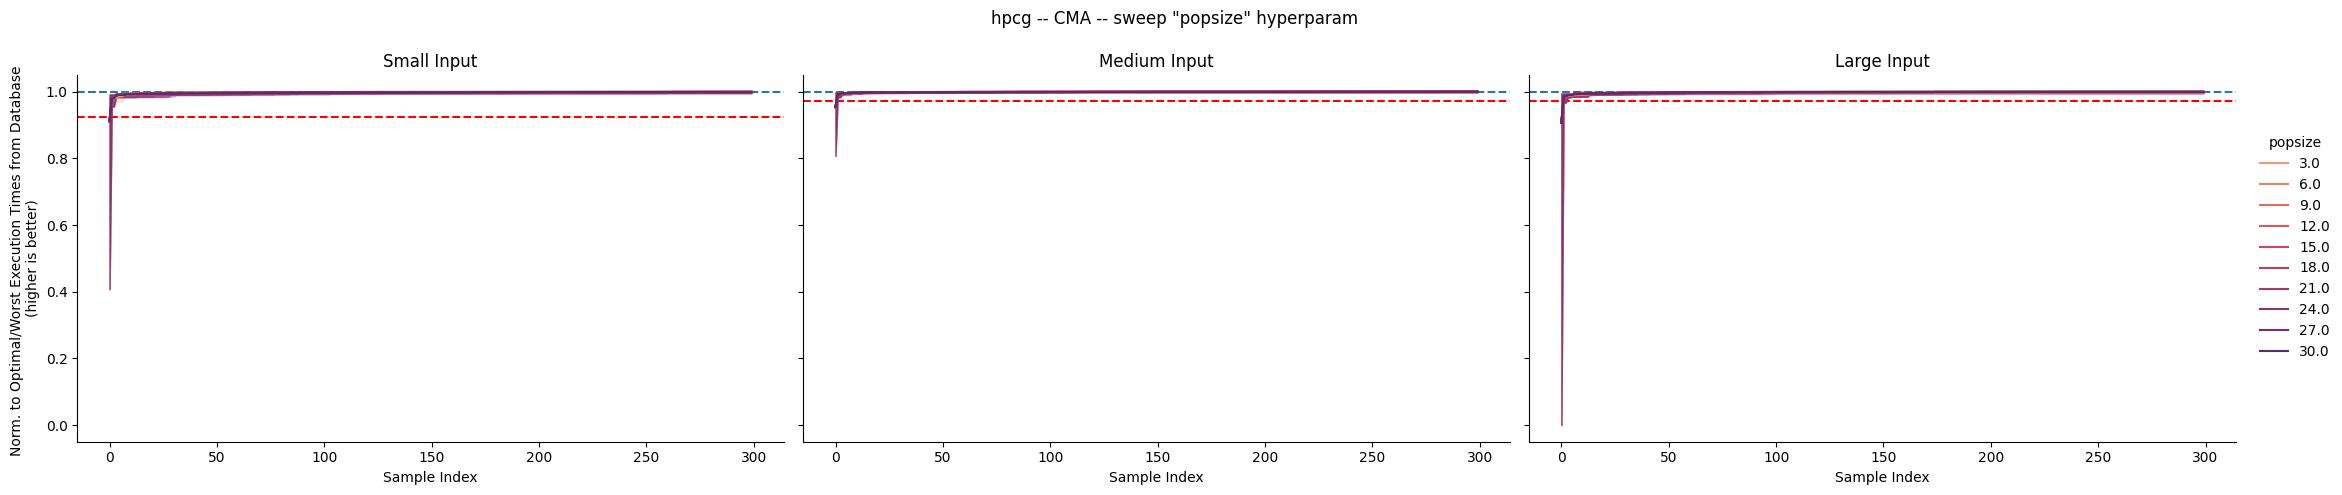

Index(['probsize', 'seed', 'globalSample', 'xtime', 'sigma', 'popsize'], dtype='object')


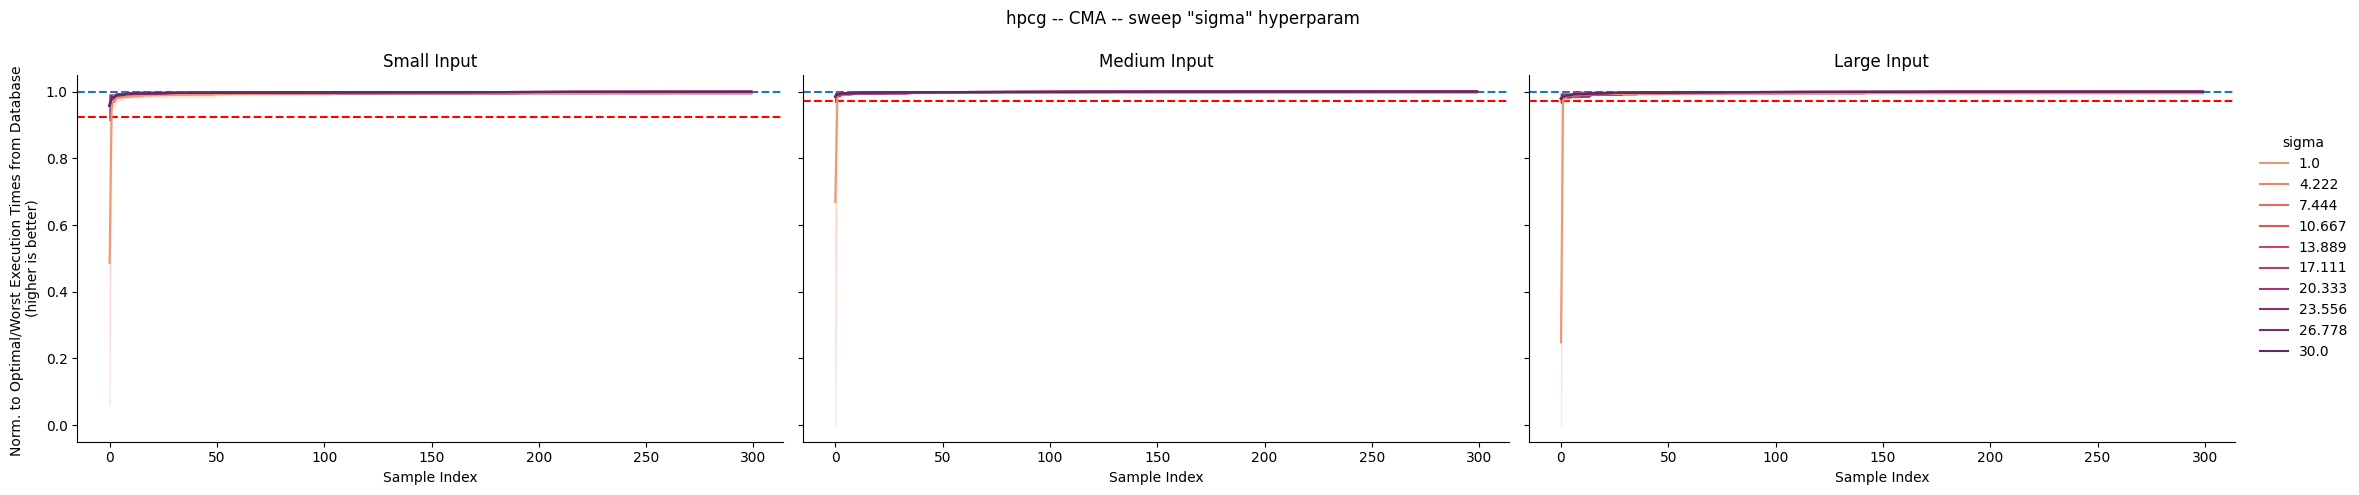

Index(['probsize', 'seed', 'globalSample', 'xtime', 'sigma', 'popsize'], dtype='object')


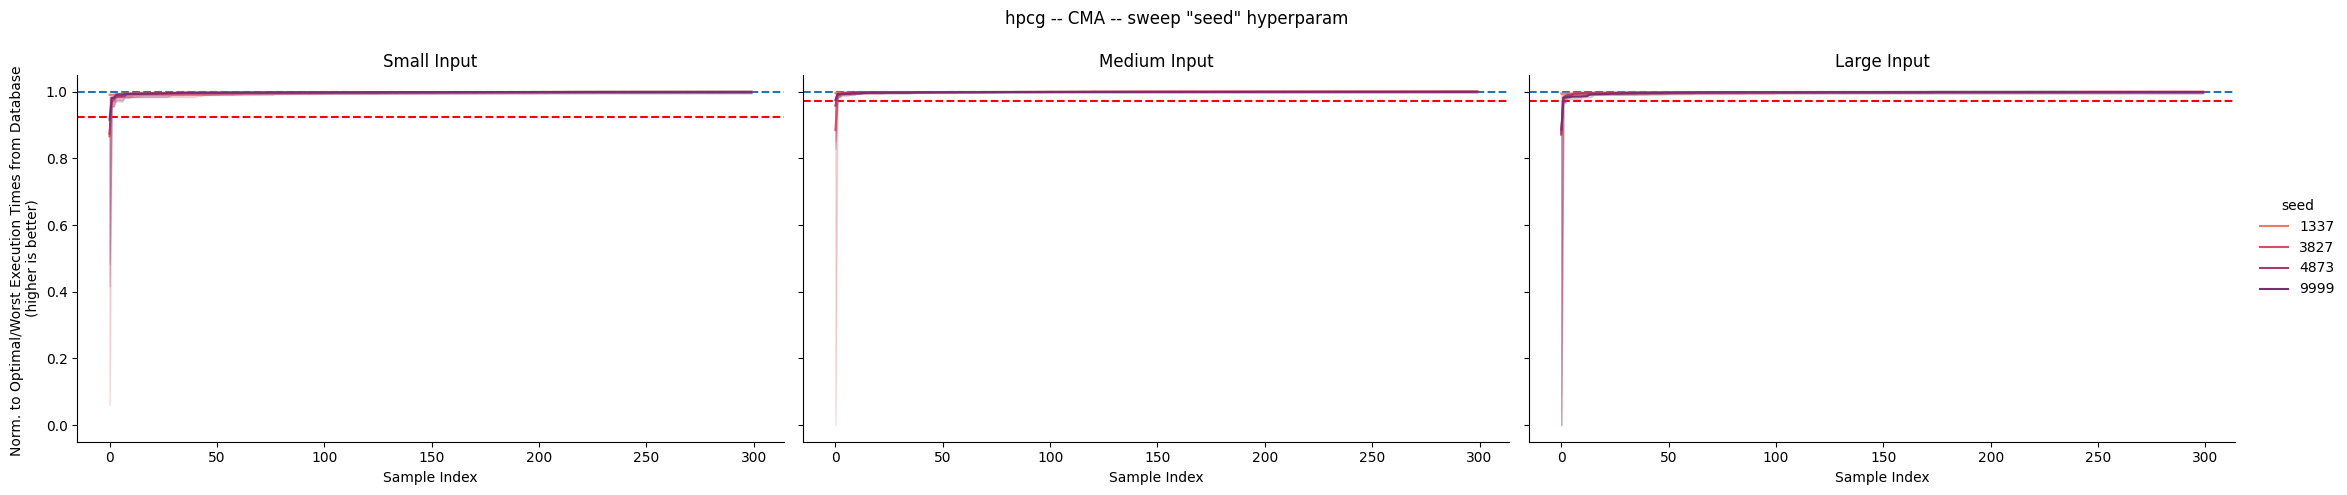

Index(['probsize', 'seed', 'globalSample', 'xtime', 'popsize', 'w', 'c1',
       'c2'],
      dtype='object')


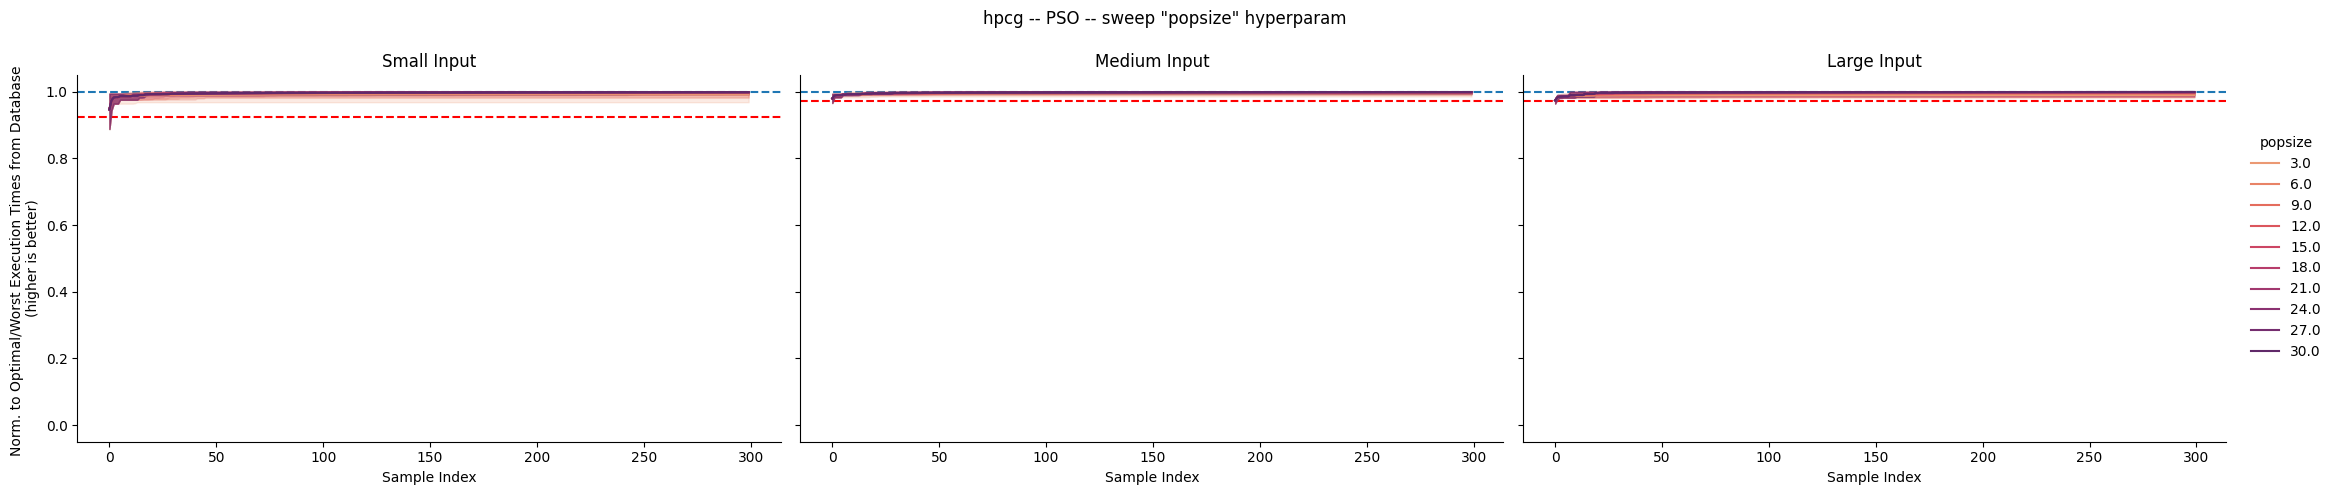

Index(['probsize', 'seed', 'globalSample', 'xtime', 'popsize', 'w', 'c1',
       'c2'],
      dtype='object')


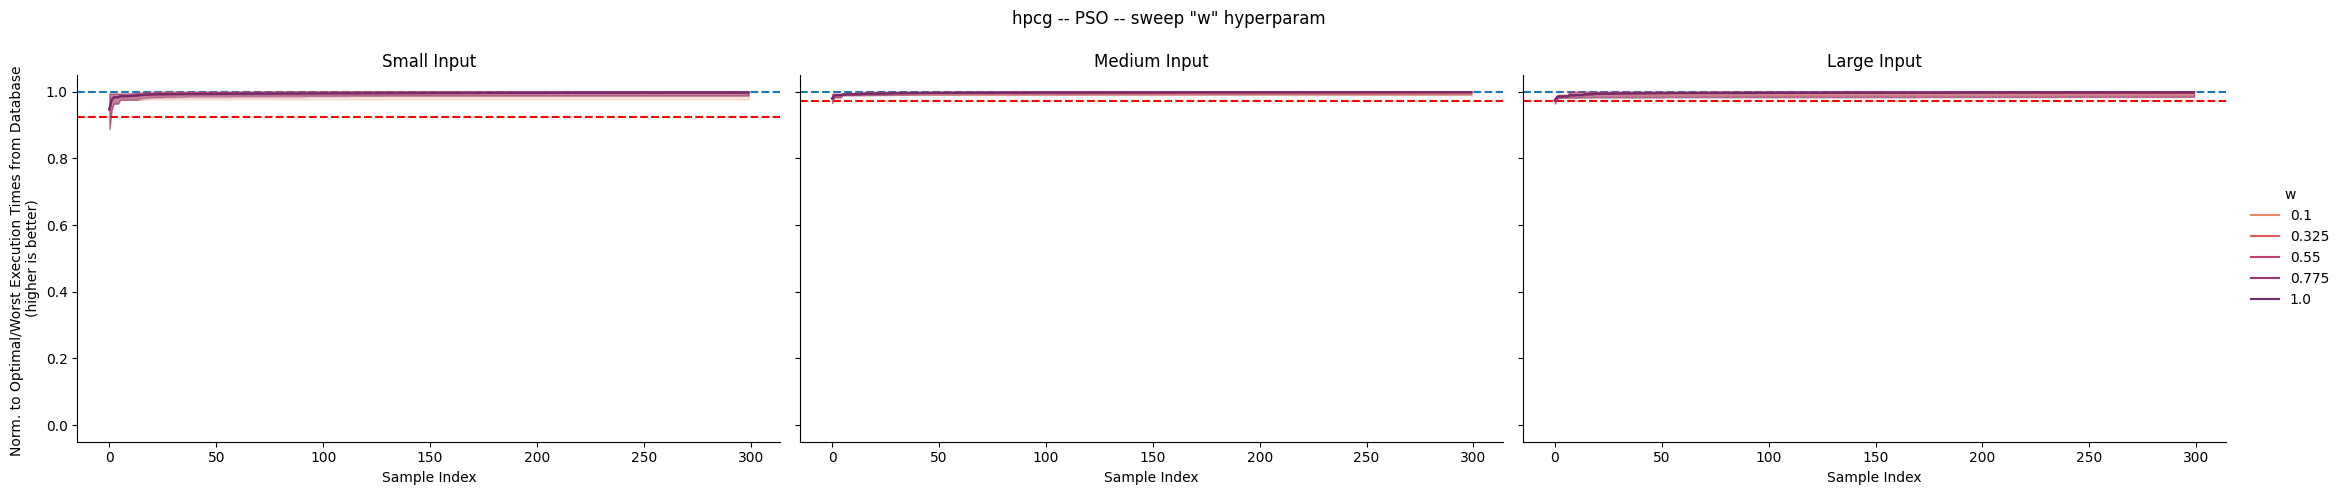

Index(['probsize', 'seed', 'globalSample', 'xtime', 'popsize', 'w', 'c1',
       'c2'],
      dtype='object')


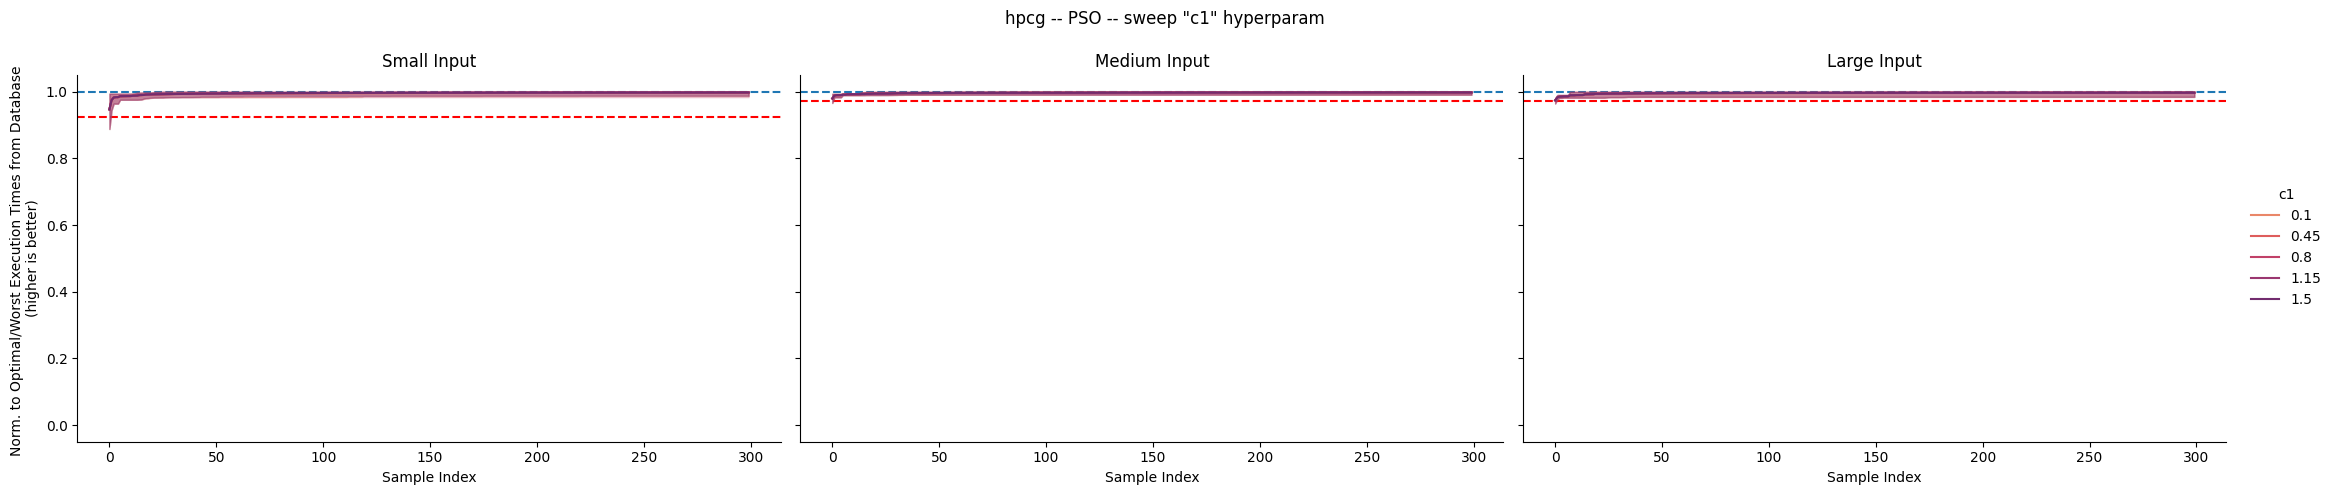

Index(['probsize', 'seed', 'globalSample', 'xtime', 'popsize', 'w', 'c1',
       'c2'],
      dtype='object')


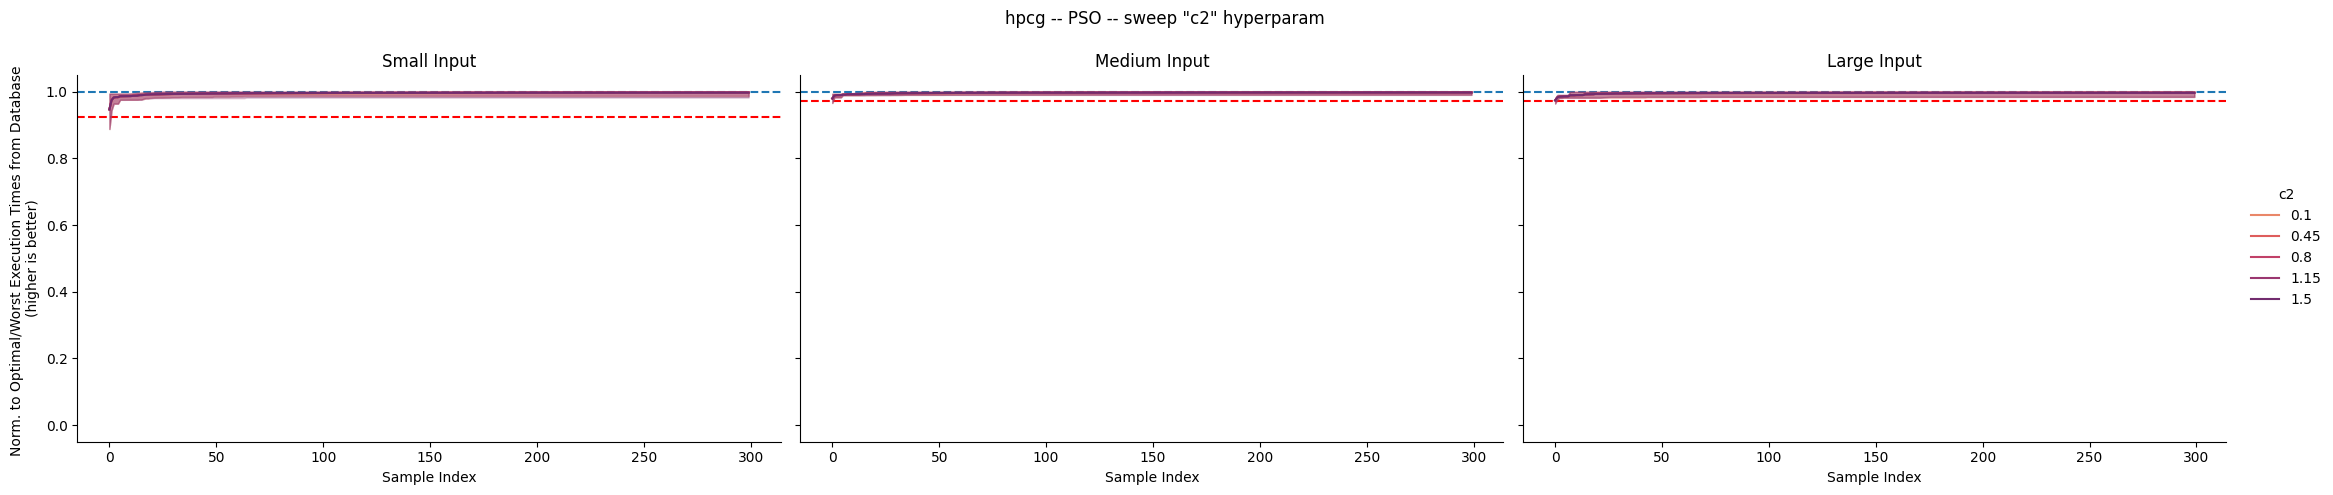

Index(['probsize', 'seed', 'globalSample', 'xtime', 'popsize', 'w', 'c1',
       'c2'],
      dtype='object')


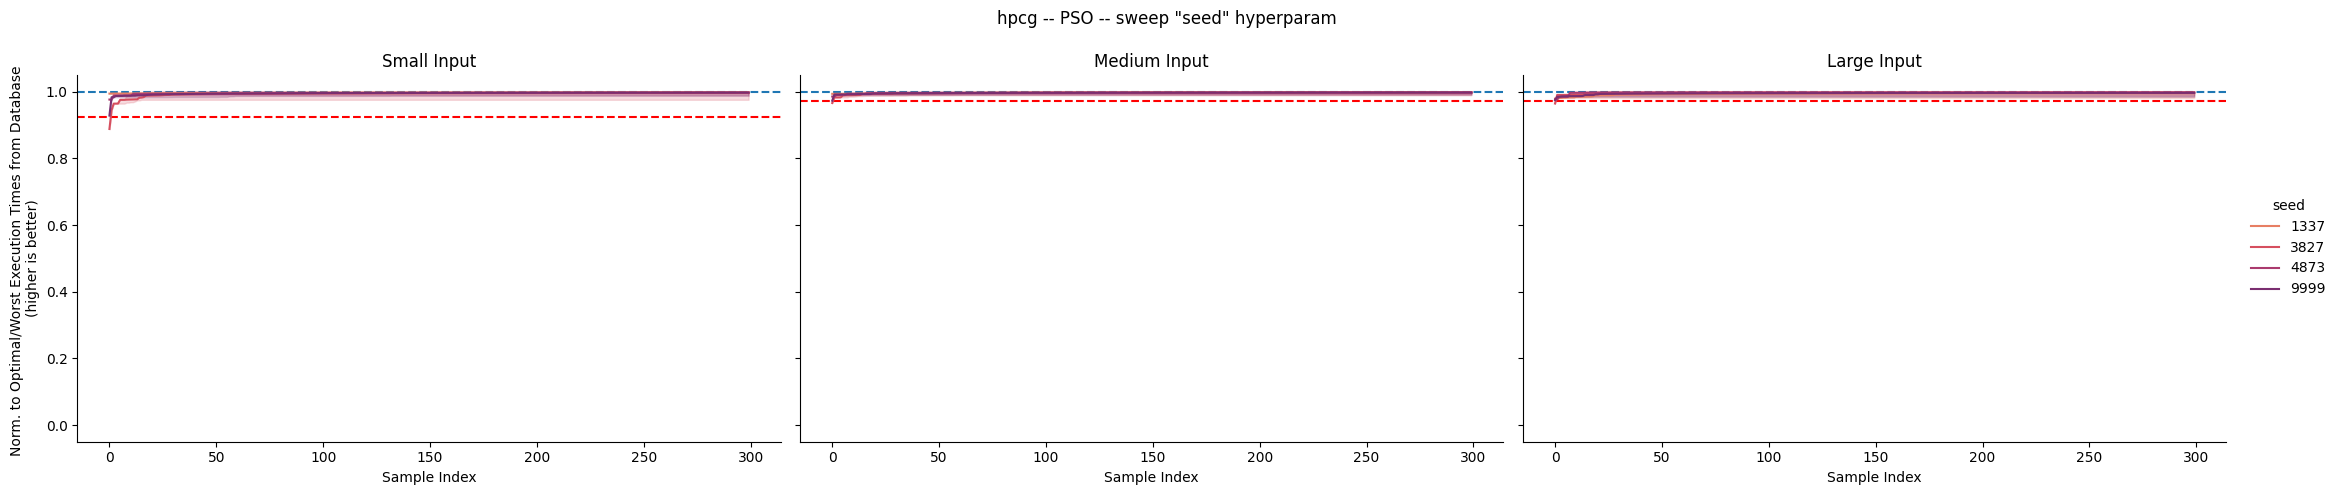

Index(['probsize', 'seed', 'globalSample', 'xtime', 'utilFnct', 'xi', 'kappa',
       'kappa_decay', 'kappa_decay_delay'],
      dtype='object')


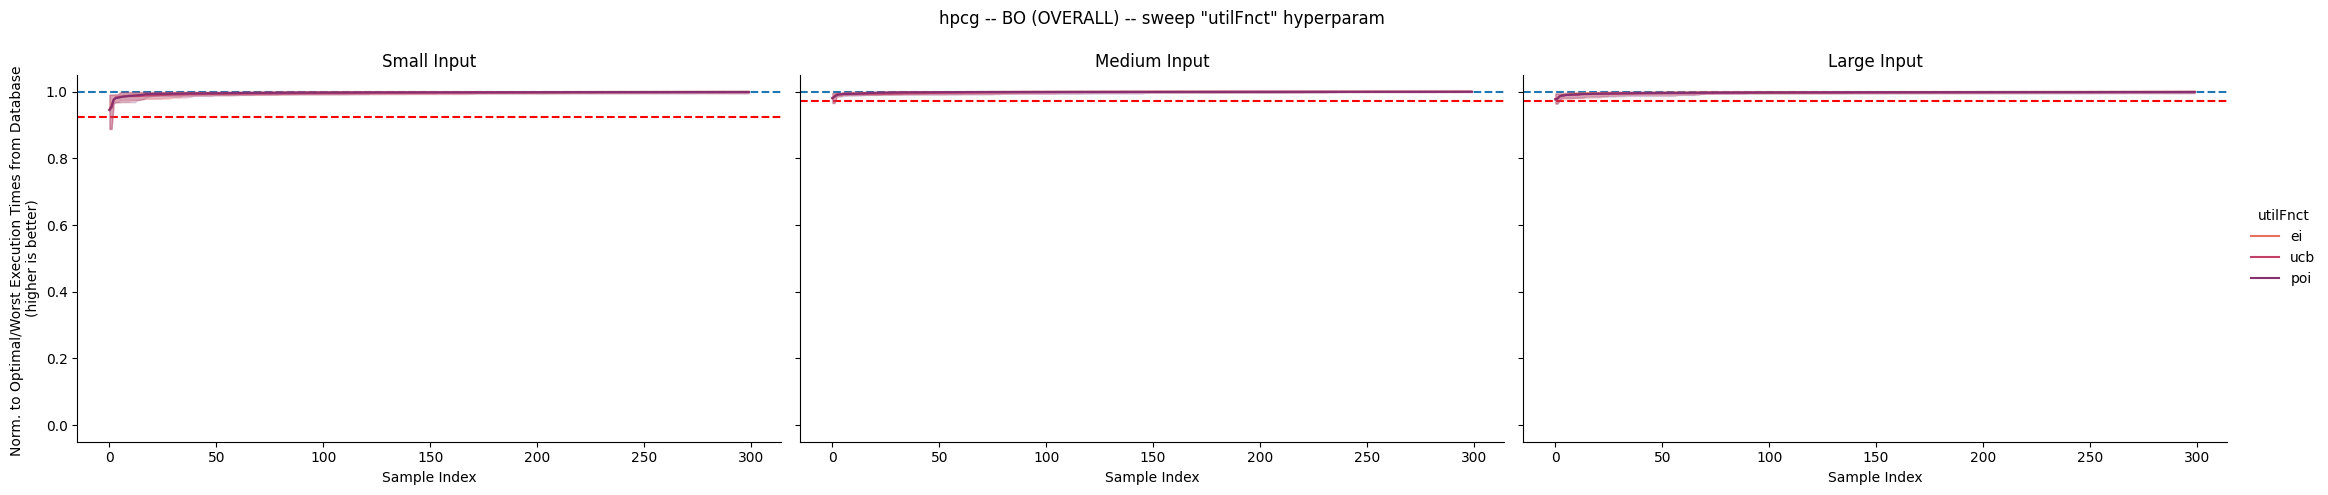

Index(['probsize', 'seed', 'globalSample', 'xtime', 'utilFnct', 'xi', 'kappa',
       'kappa_decay', 'kappa_decay_delay'],
      dtype='object')


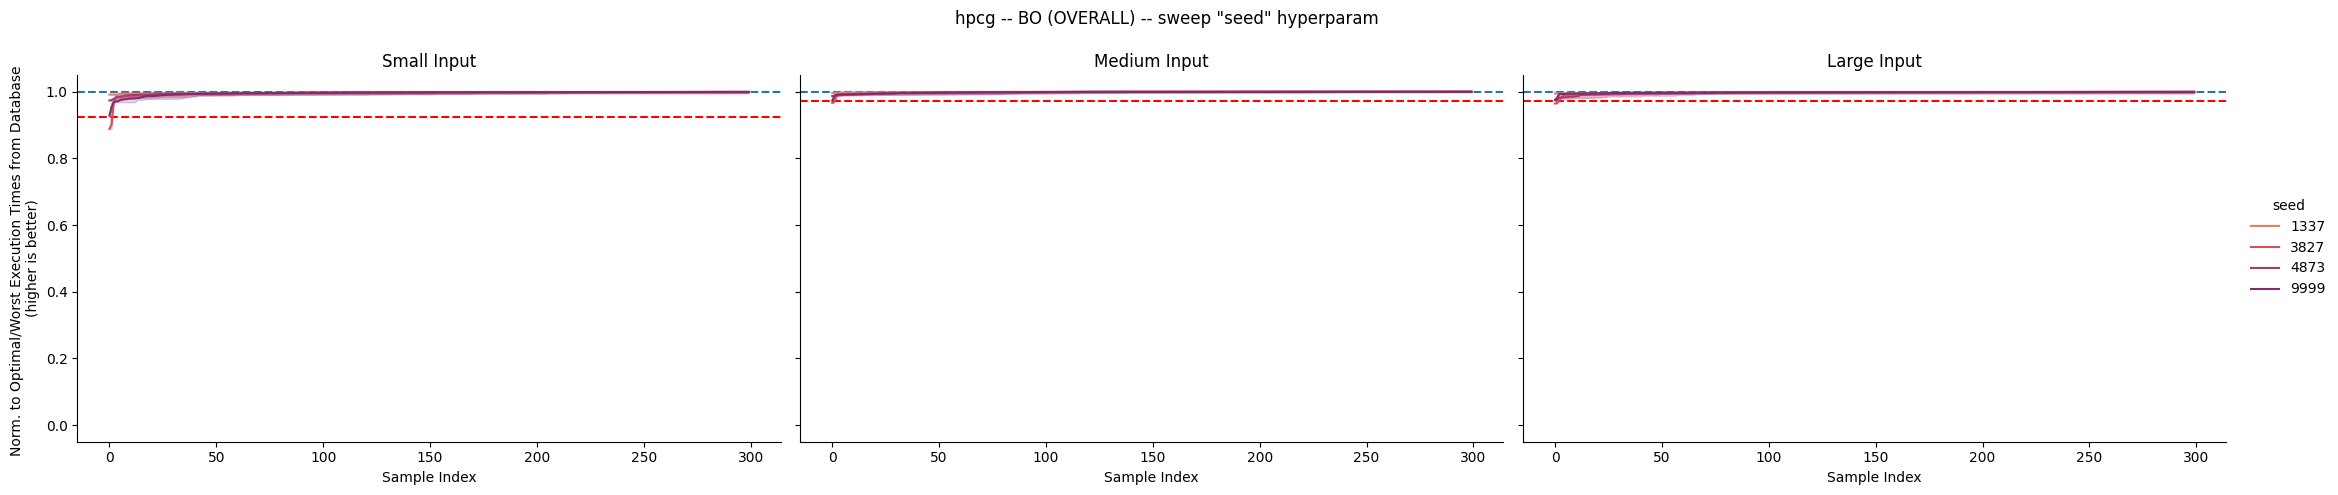

Index(['probsize', 'seed', 'globalSample', 'xtime', 'utilFnct', 'xi', 'kappa',
       'kappa_decay', 'kappa_decay_delay'],
      dtype='object')


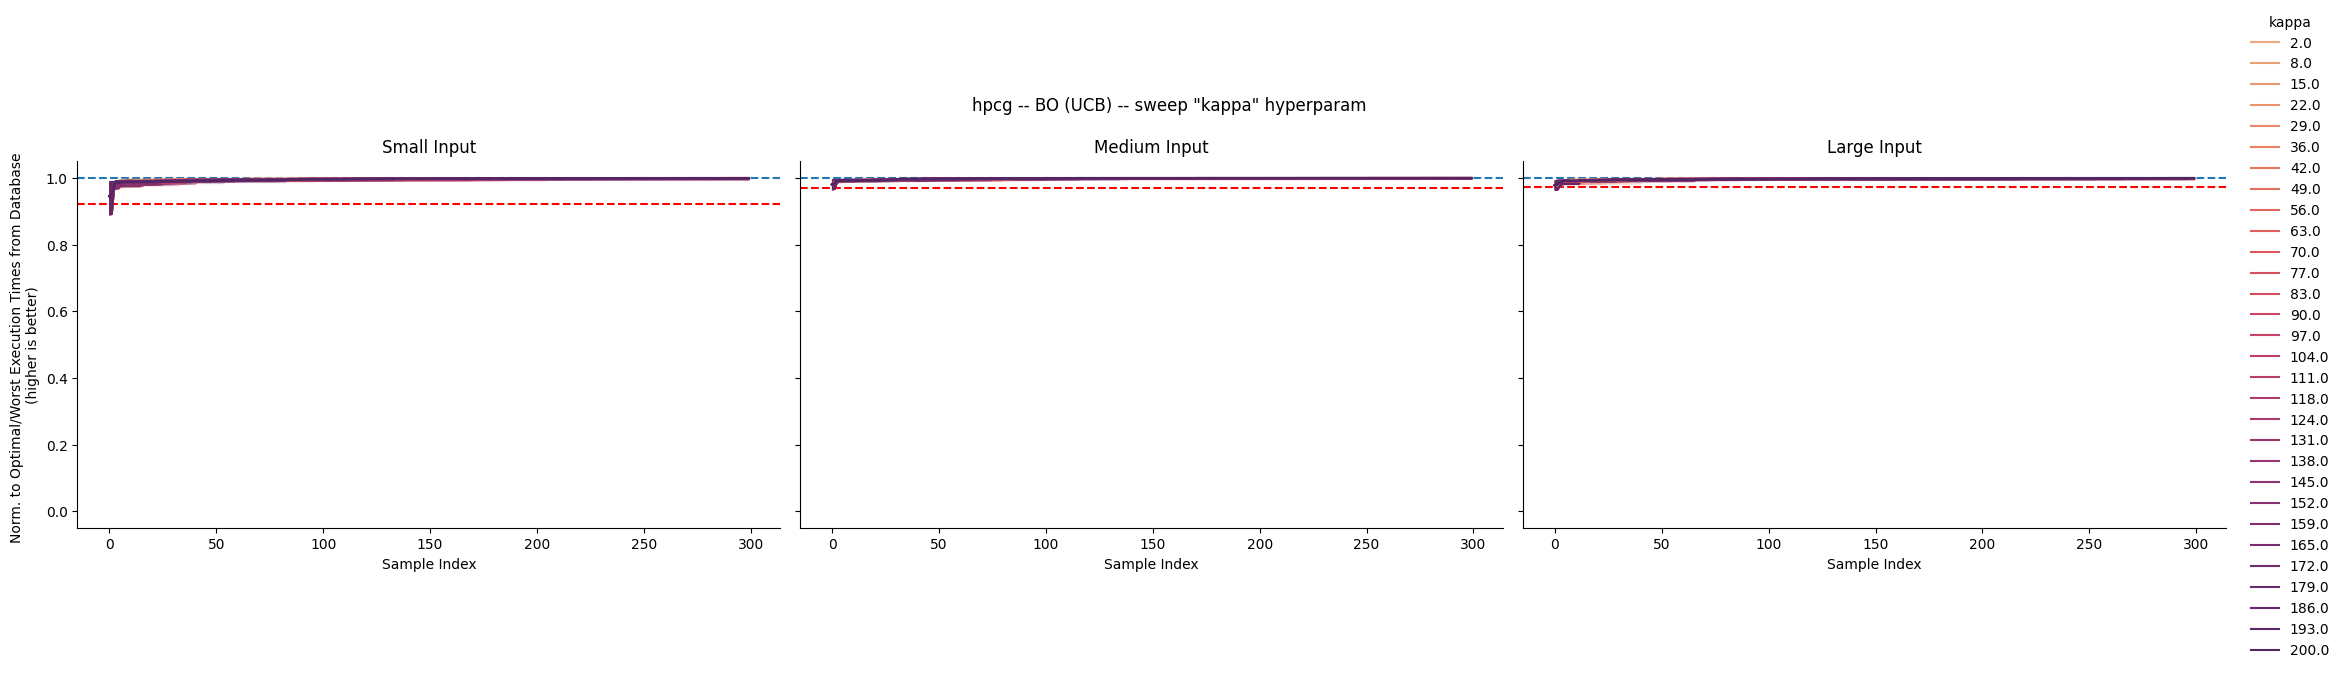

Index(['probsize', 'seed', 'globalSample', 'xtime', 'utilFnct', 'xi', 'kappa',
       'kappa_decay', 'kappa_decay_delay'],
      dtype='object')


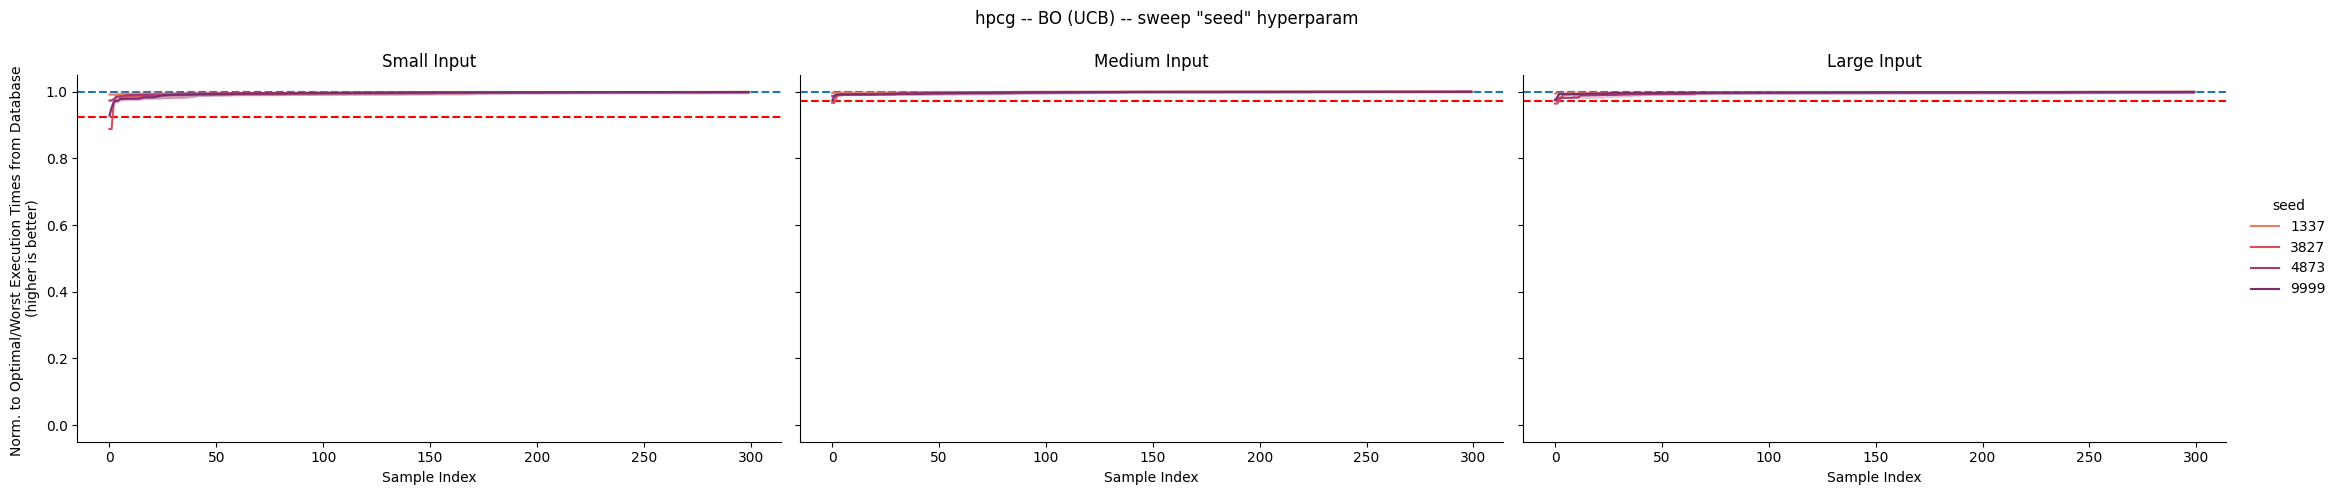

Index(['probsize', 'seed', 'globalSample', 'xtime', 'utilFnct', 'xi', 'kappa',
       'kappa_decay', 'kappa_decay_delay'],
      dtype='object')


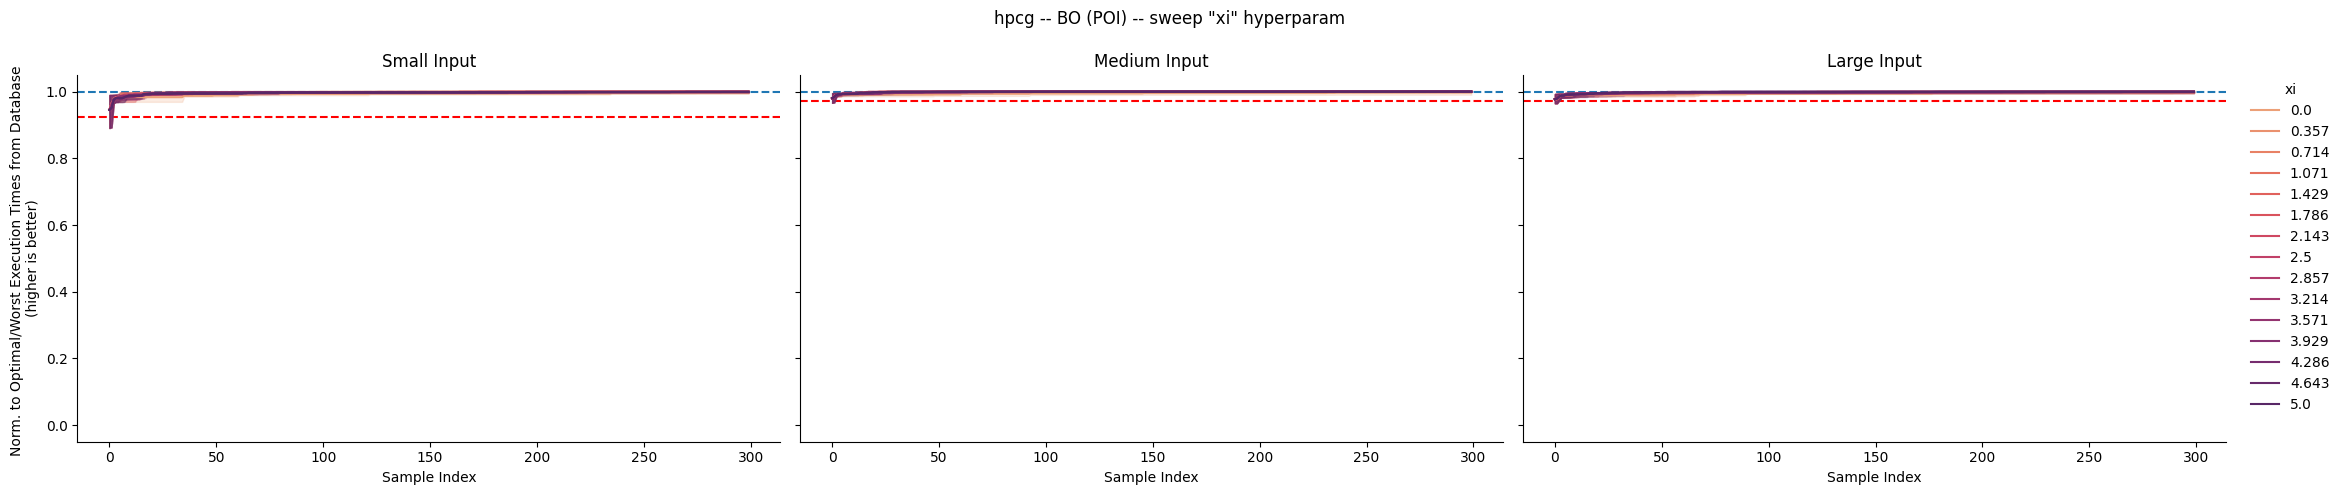

Index(['probsize', 'seed', 'globalSample', 'xtime', 'utilFnct', 'xi', 'kappa',
       'kappa_decay', 'kappa_decay_delay'],
      dtype='object')


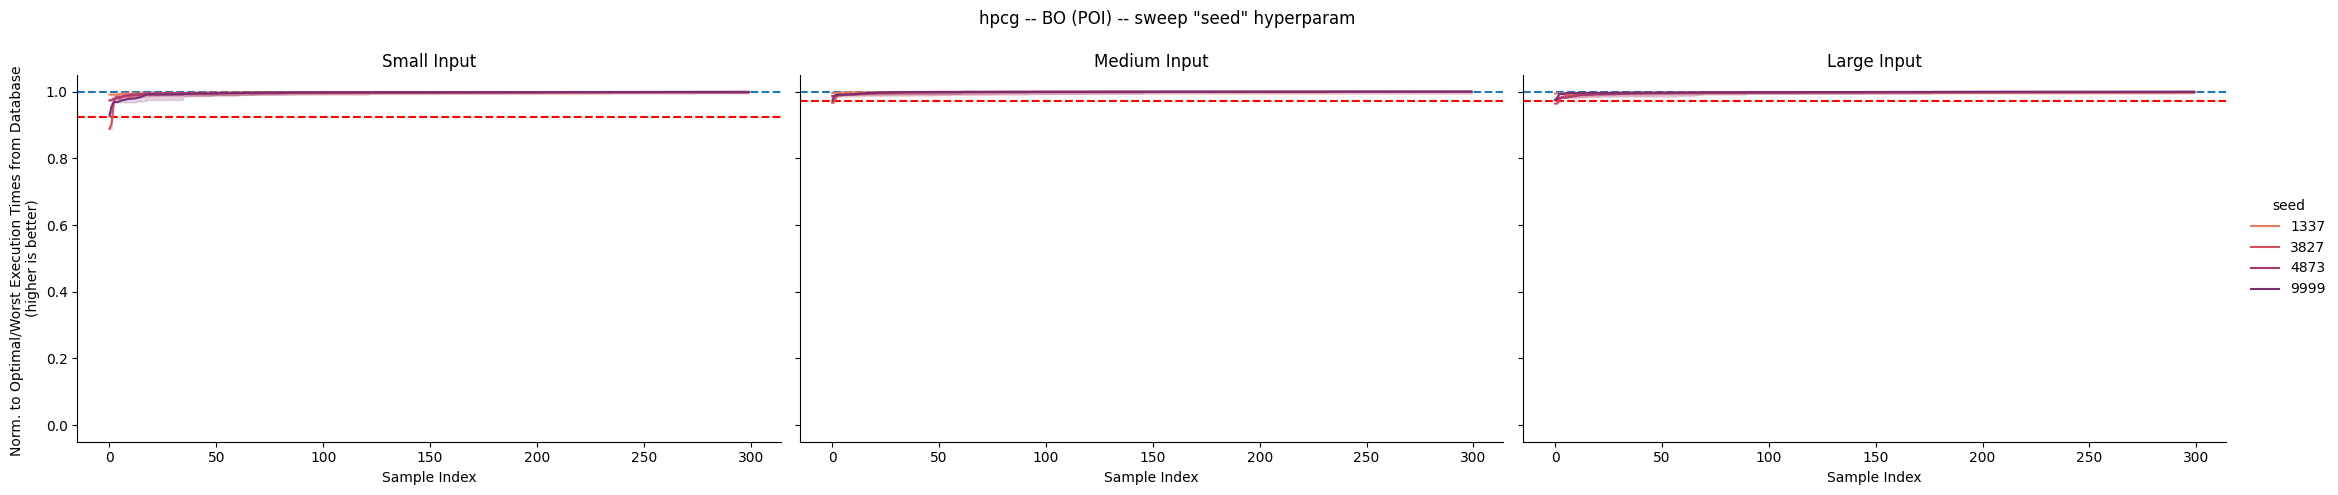

Index(['probsize', 'seed', 'globalSample', 'xtime', 'utilFnct', 'xi', 'kappa',
       'kappa_decay', 'kappa_decay_delay'],
      dtype='object')


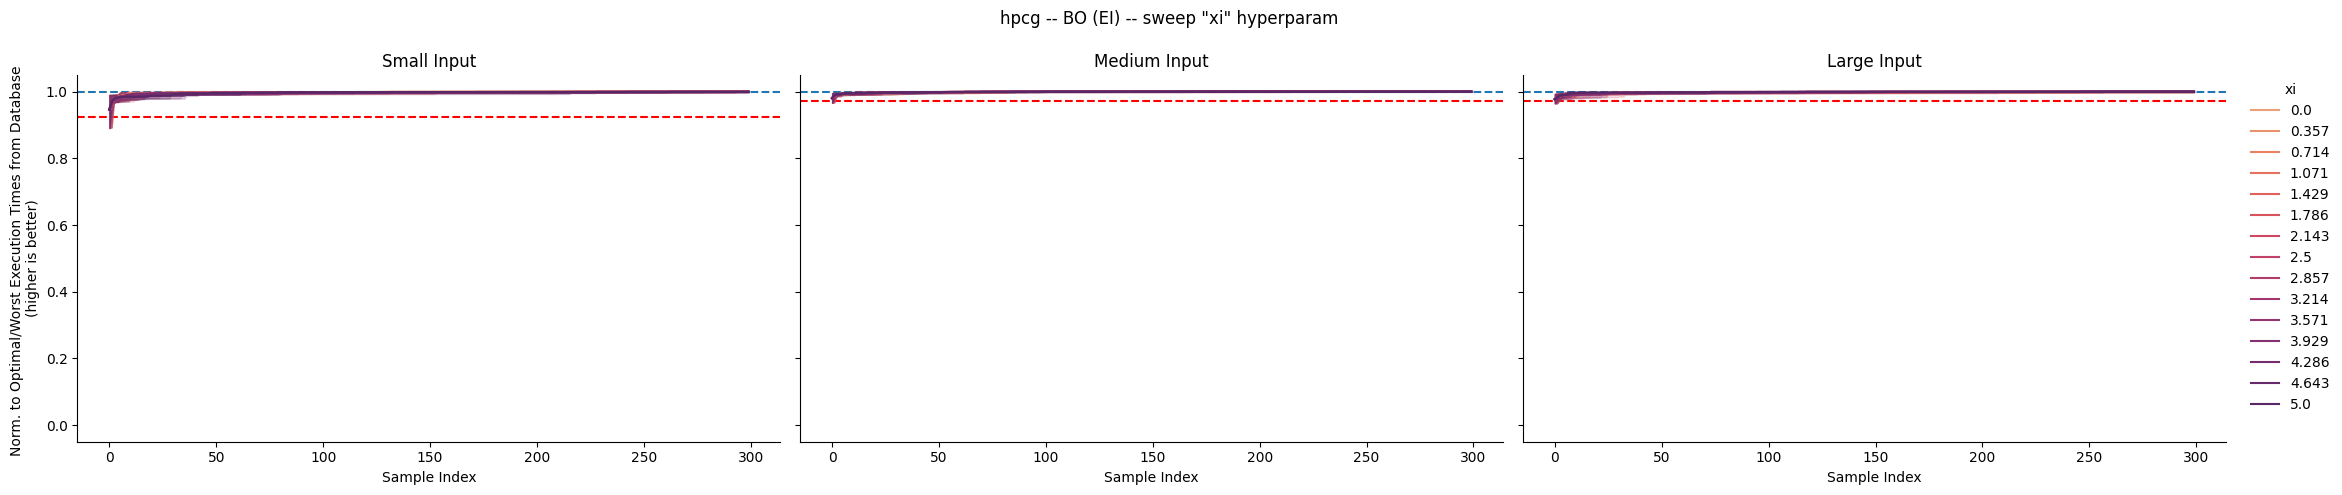

Index(['probsize', 'seed', 'globalSample', 'xtime', 'utilFnct', 'xi', 'kappa',
       'kappa_decay', 'kappa_decay_delay'],
      dtype='object')


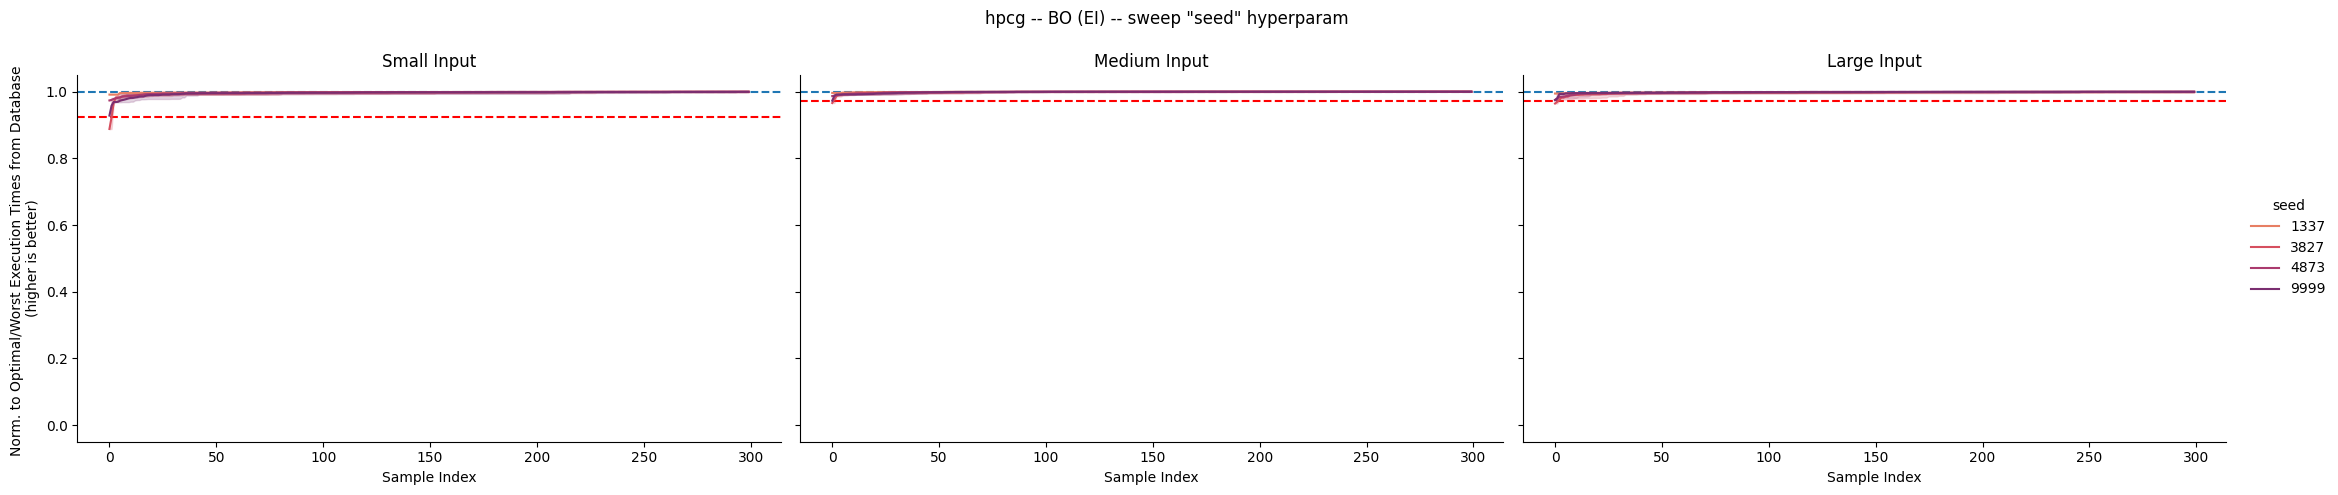

Index(['probsize', 'seed', 'globalSample', 'xtime', 'sigma', 'popsize'], dtype='object')


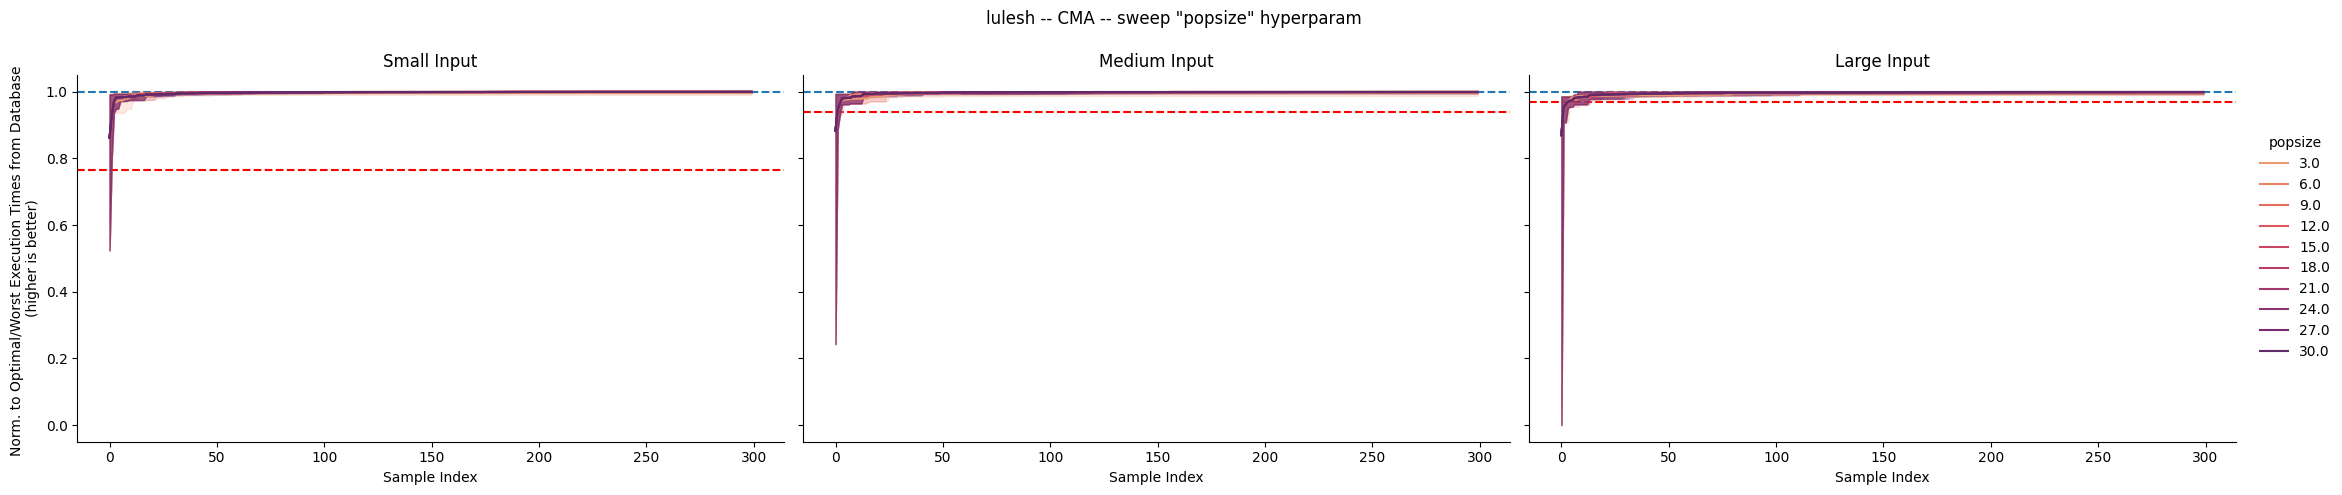

Index(['probsize', 'seed', 'globalSample', 'xtime', 'sigma', 'popsize'], dtype='object')


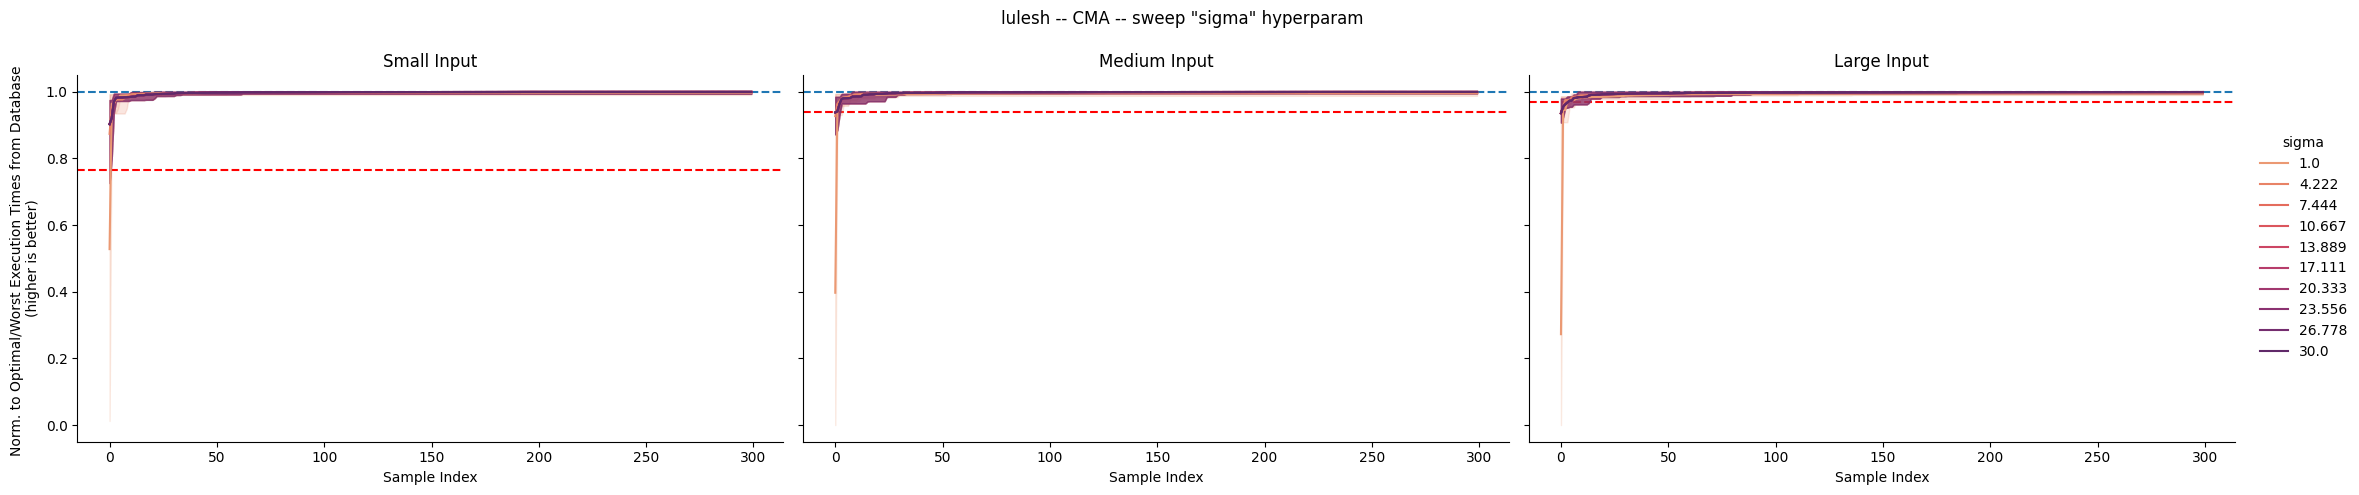

Index(['probsize', 'seed', 'globalSample', 'xtime', 'sigma', 'popsize'], dtype='object')


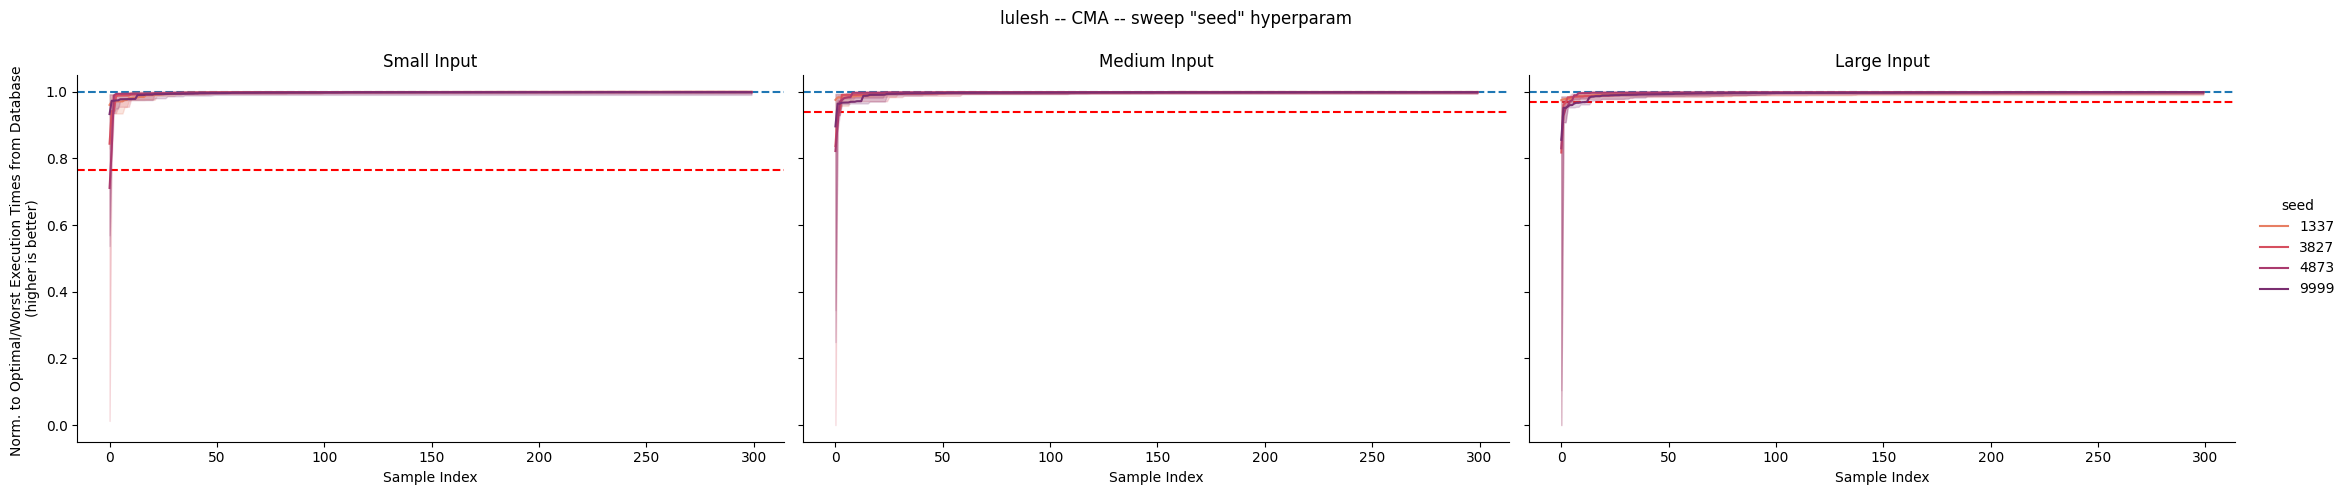

Index(['probsize', 'seed', 'globalSample', 'xtime', 'popsize', 'w', 'c1',
       'c2'],
      dtype='object')


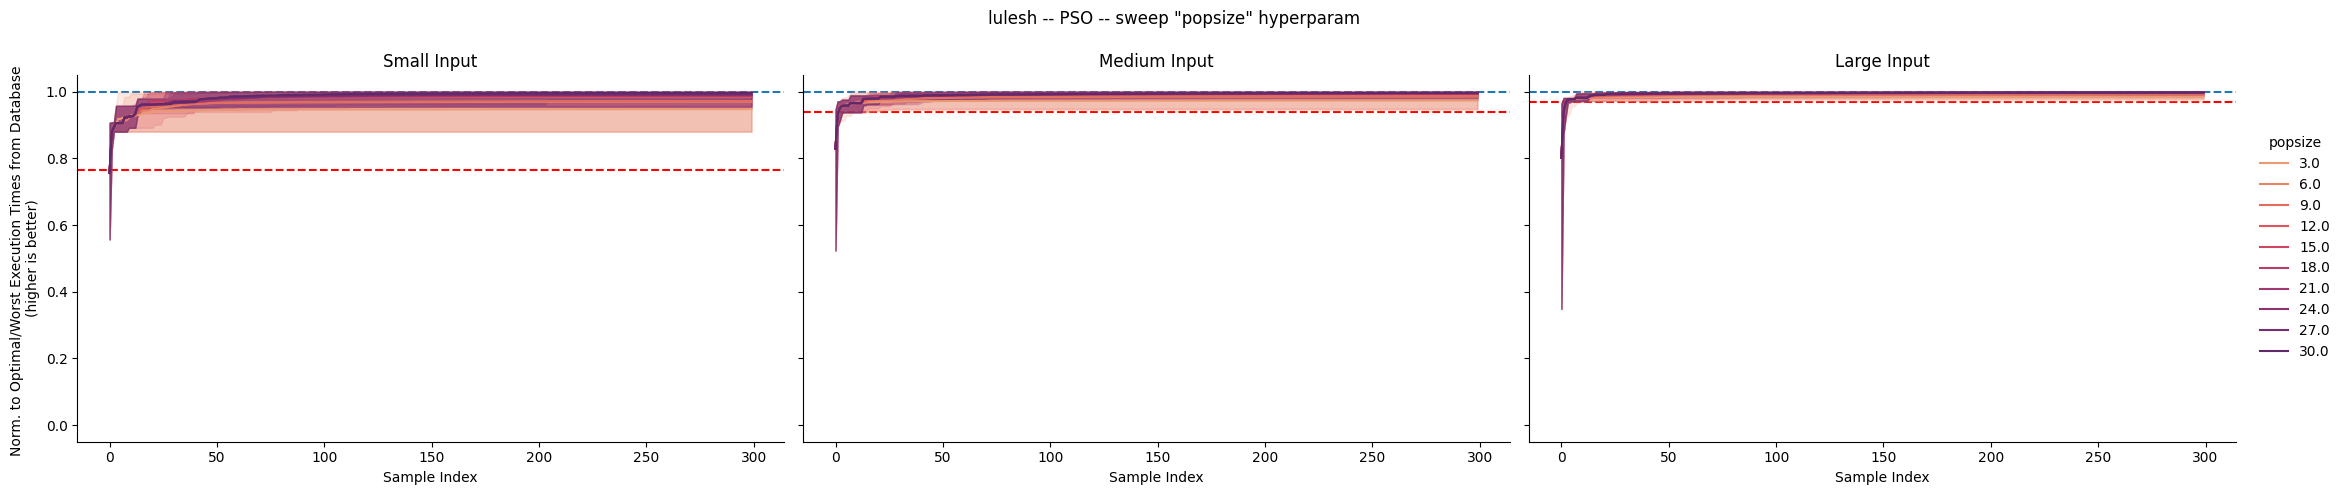

Index(['probsize', 'seed', 'globalSample', 'xtime', 'popsize', 'w', 'c1',
       'c2'],
      dtype='object')


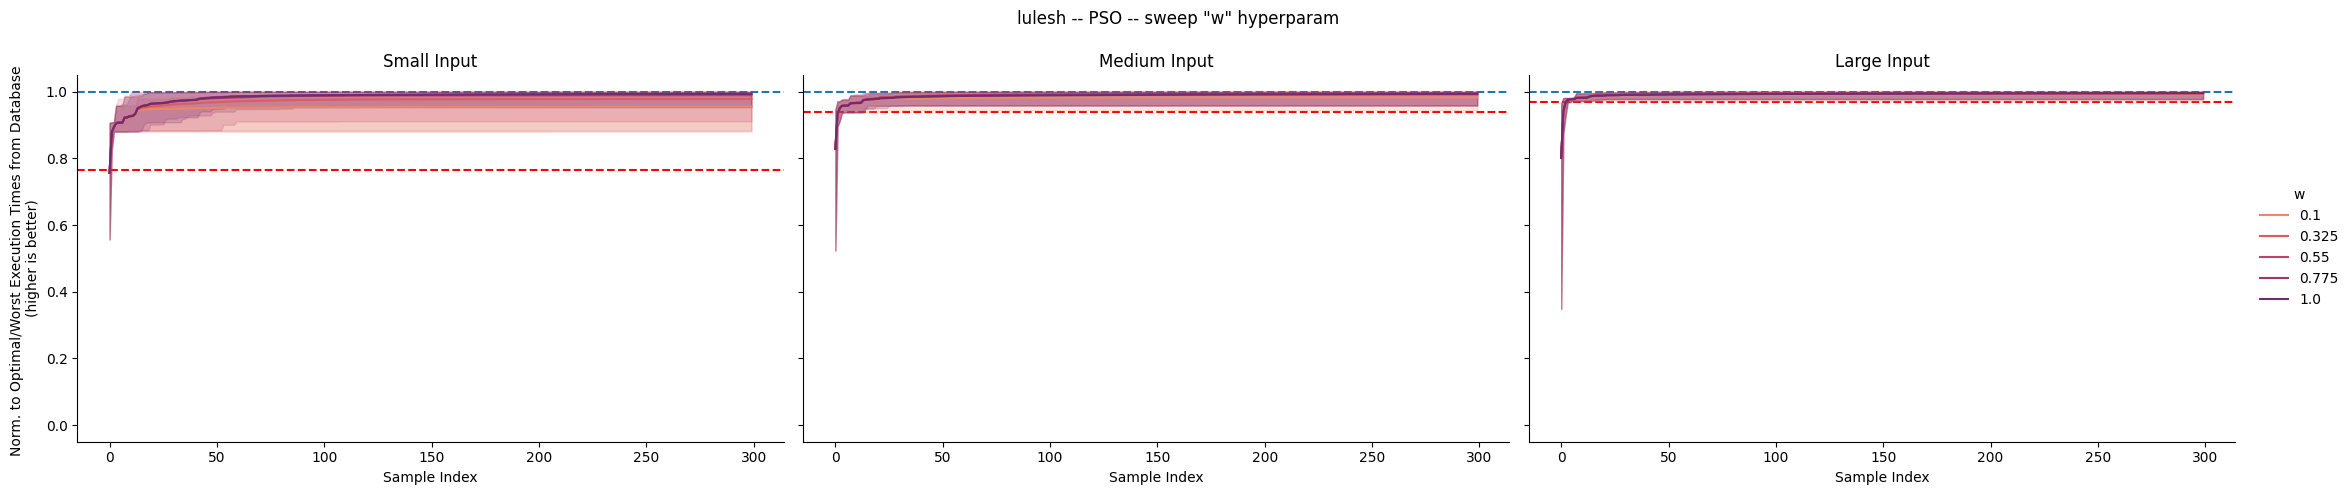

Index(['probsize', 'seed', 'globalSample', 'xtime', 'popsize', 'w', 'c1',
       'c2'],
      dtype='object')


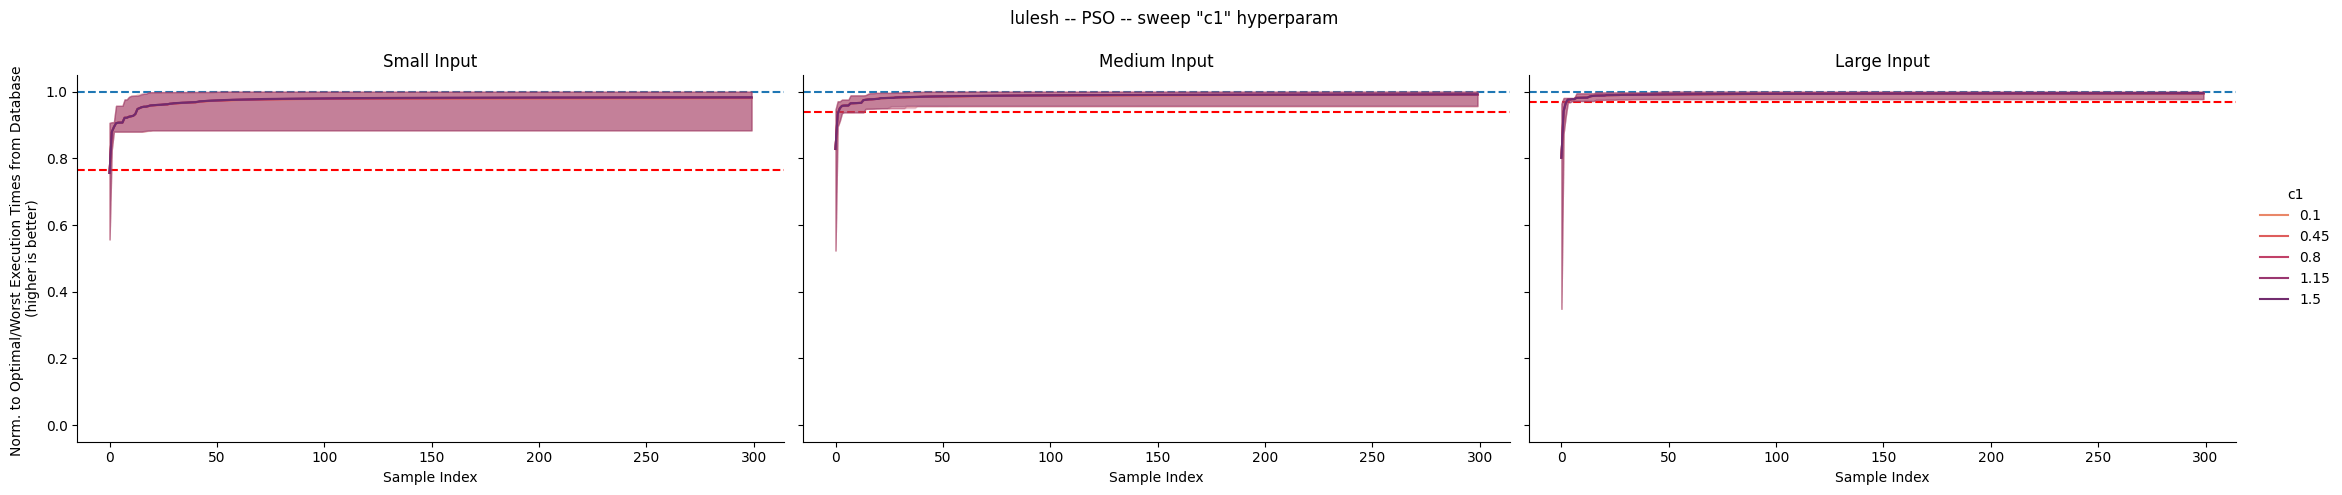

Index(['probsize', 'seed', 'globalSample', 'xtime', 'popsize', 'w', 'c1',
       'c2'],
      dtype='object')


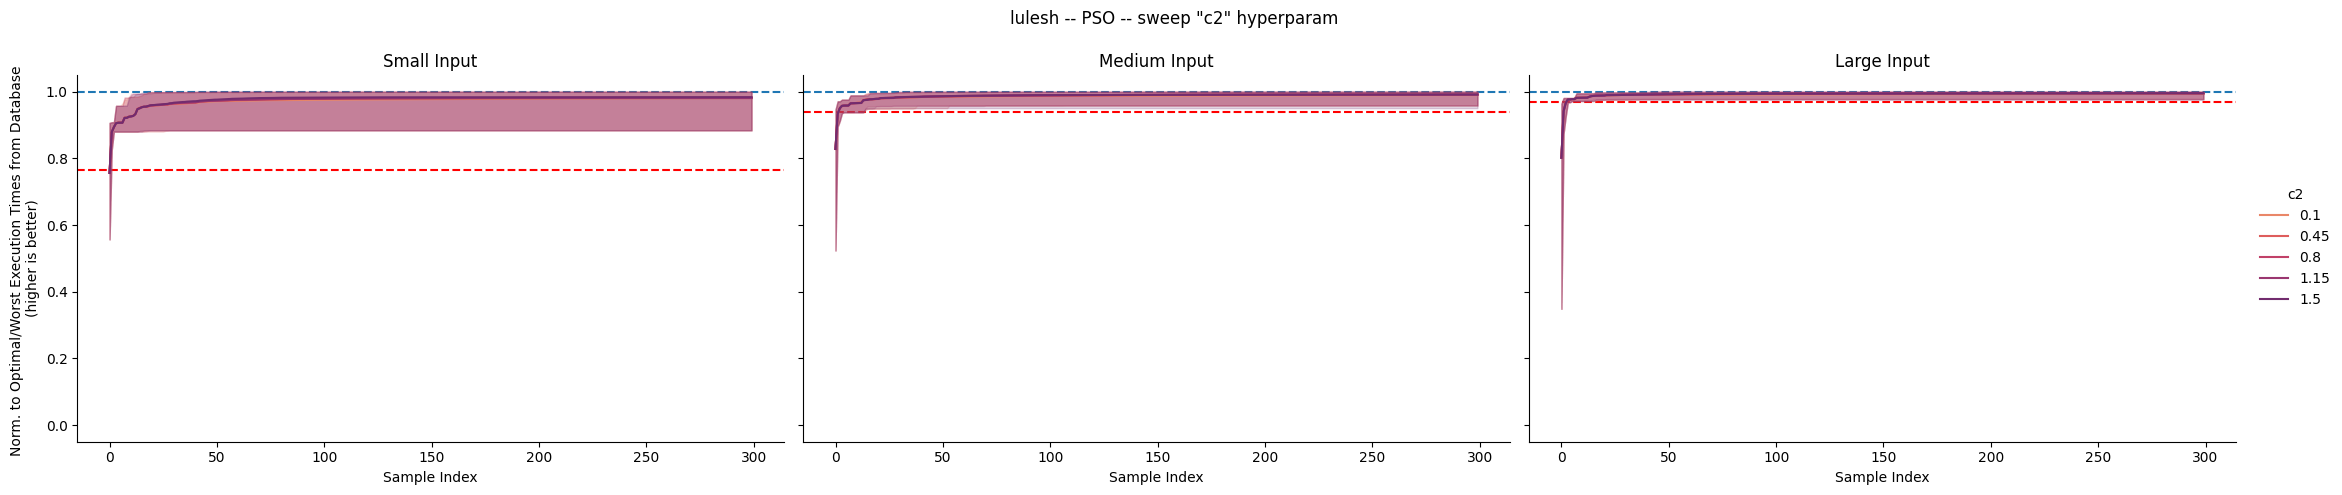

Index(['probsize', 'seed', 'globalSample', 'xtime', 'popsize', 'w', 'c1',
       'c2'],
      dtype='object')


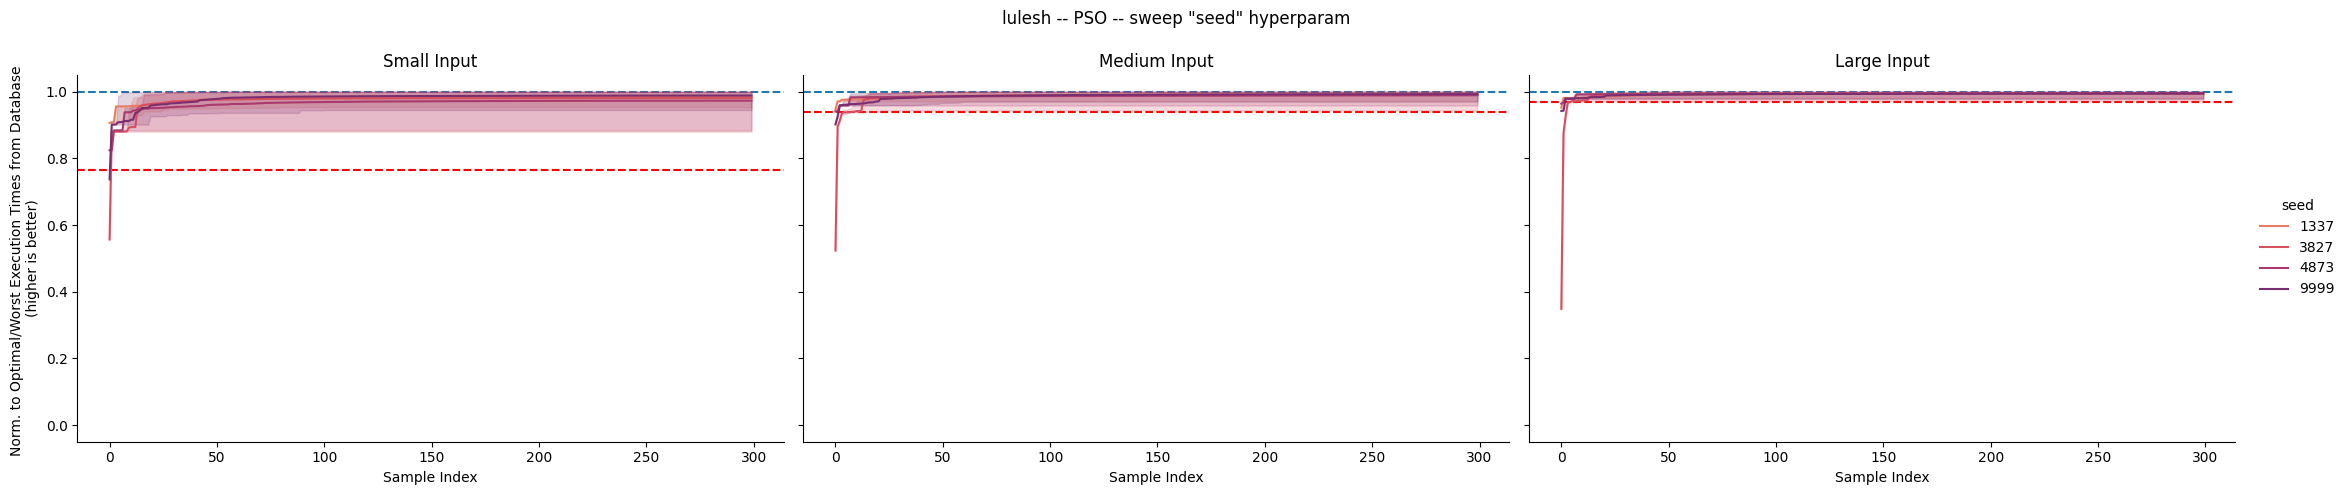

Index(['probsize', 'seed', 'globalSample', 'xtime', 'utilFnct', 'xi', 'kappa',
       'kappa_decay', 'kappa_decay_delay'],
      dtype='object')


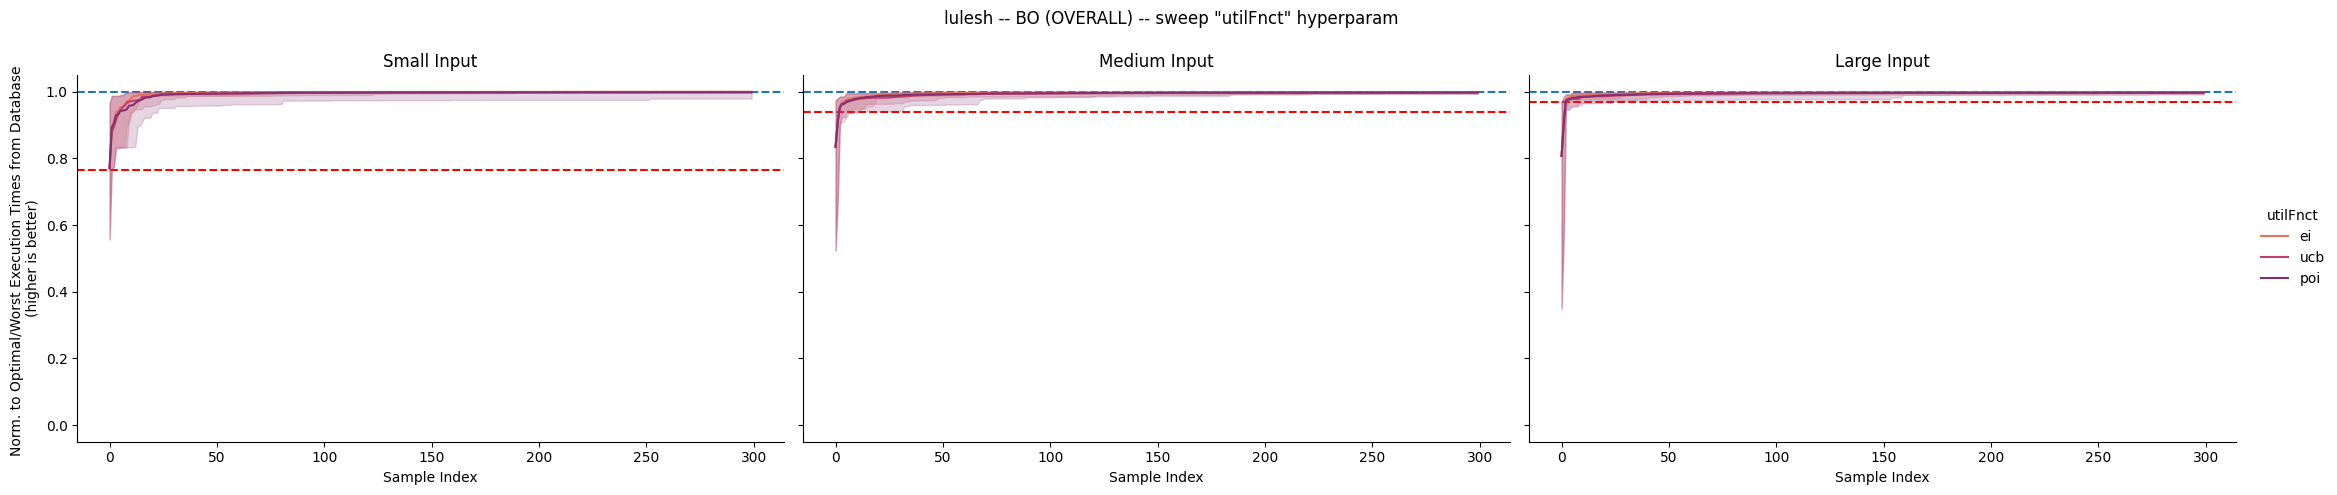

Index(['probsize', 'seed', 'globalSample', 'xtime', 'utilFnct', 'xi', 'kappa',
       'kappa_decay', 'kappa_decay_delay'],
      dtype='object')


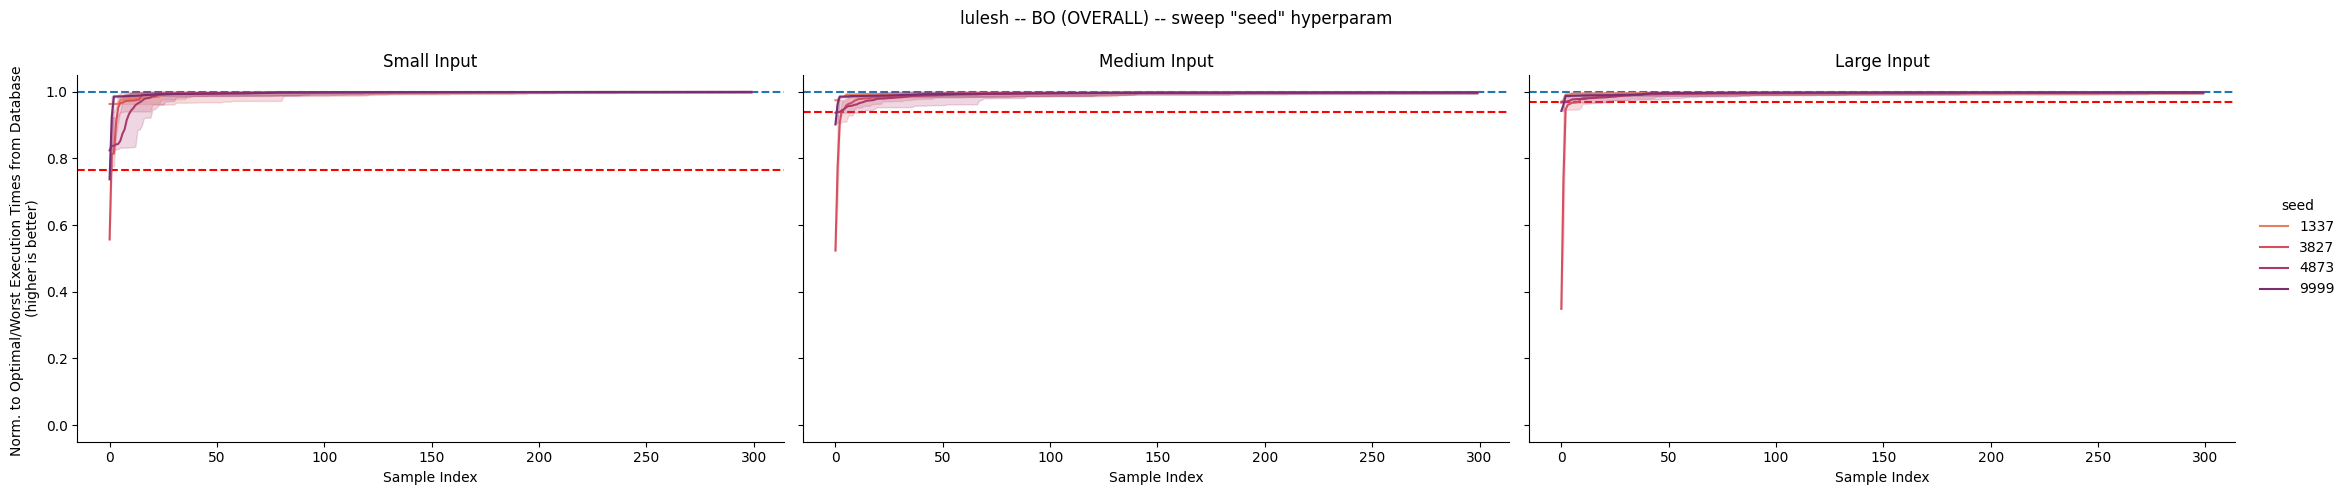

Index(['probsize', 'seed', 'globalSample', 'xtime', 'utilFnct', 'xi', 'kappa',
       'kappa_decay', 'kappa_decay_delay'],
      dtype='object')


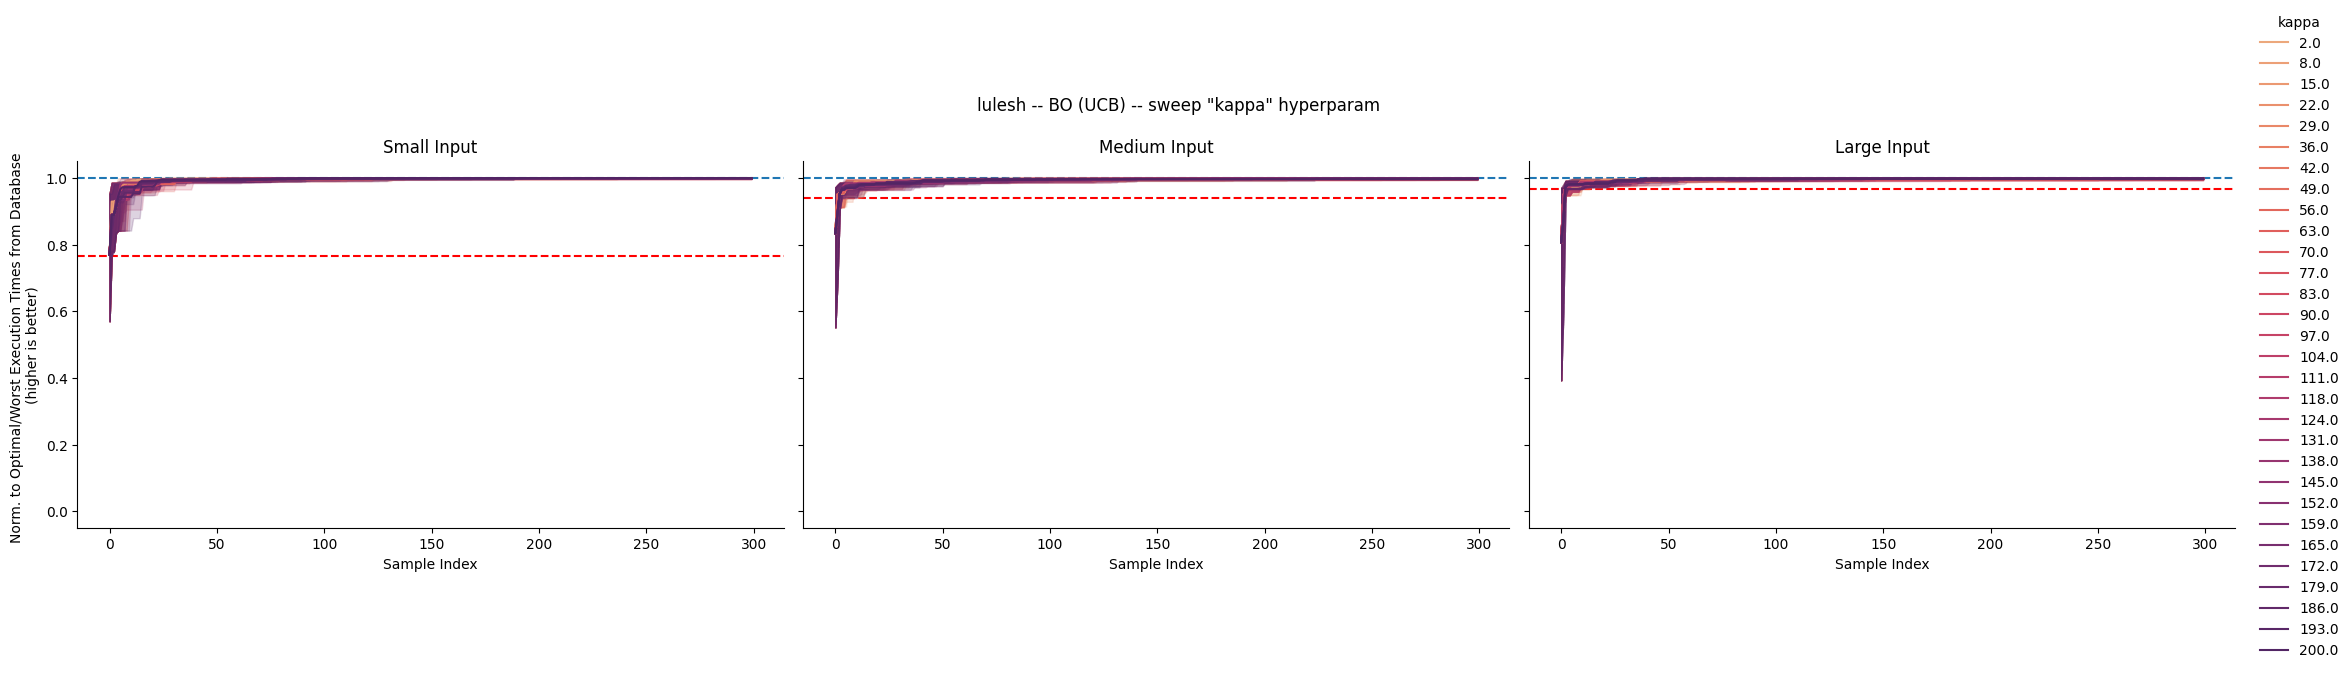

Index(['probsize', 'seed', 'globalSample', 'xtime', 'utilFnct', 'xi', 'kappa',
       'kappa_decay', 'kappa_decay_delay'],
      dtype='object')


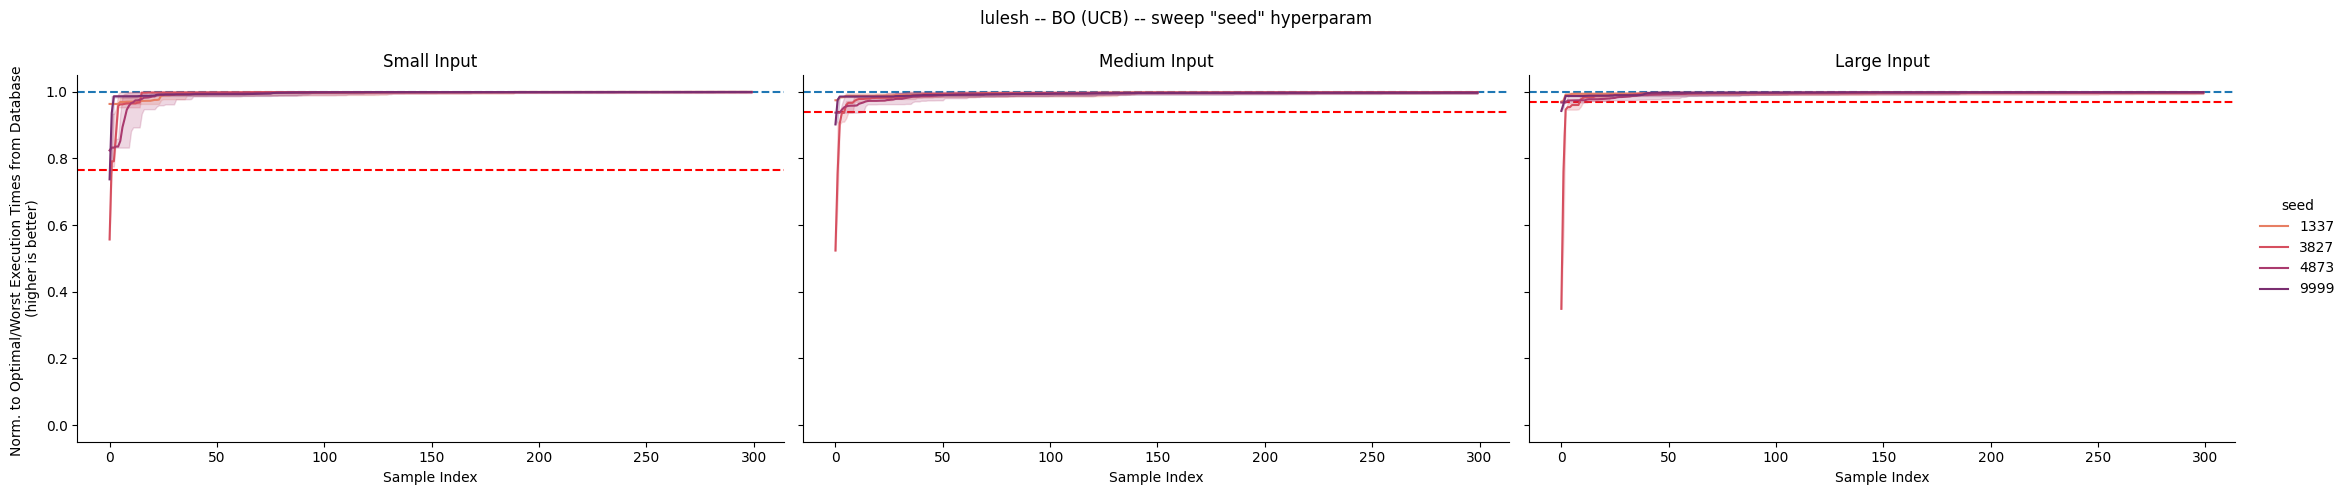

Index(['probsize', 'seed', 'globalSample', 'xtime', 'utilFnct', 'xi', 'kappa',
       'kappa_decay', 'kappa_decay_delay'],
      dtype='object')


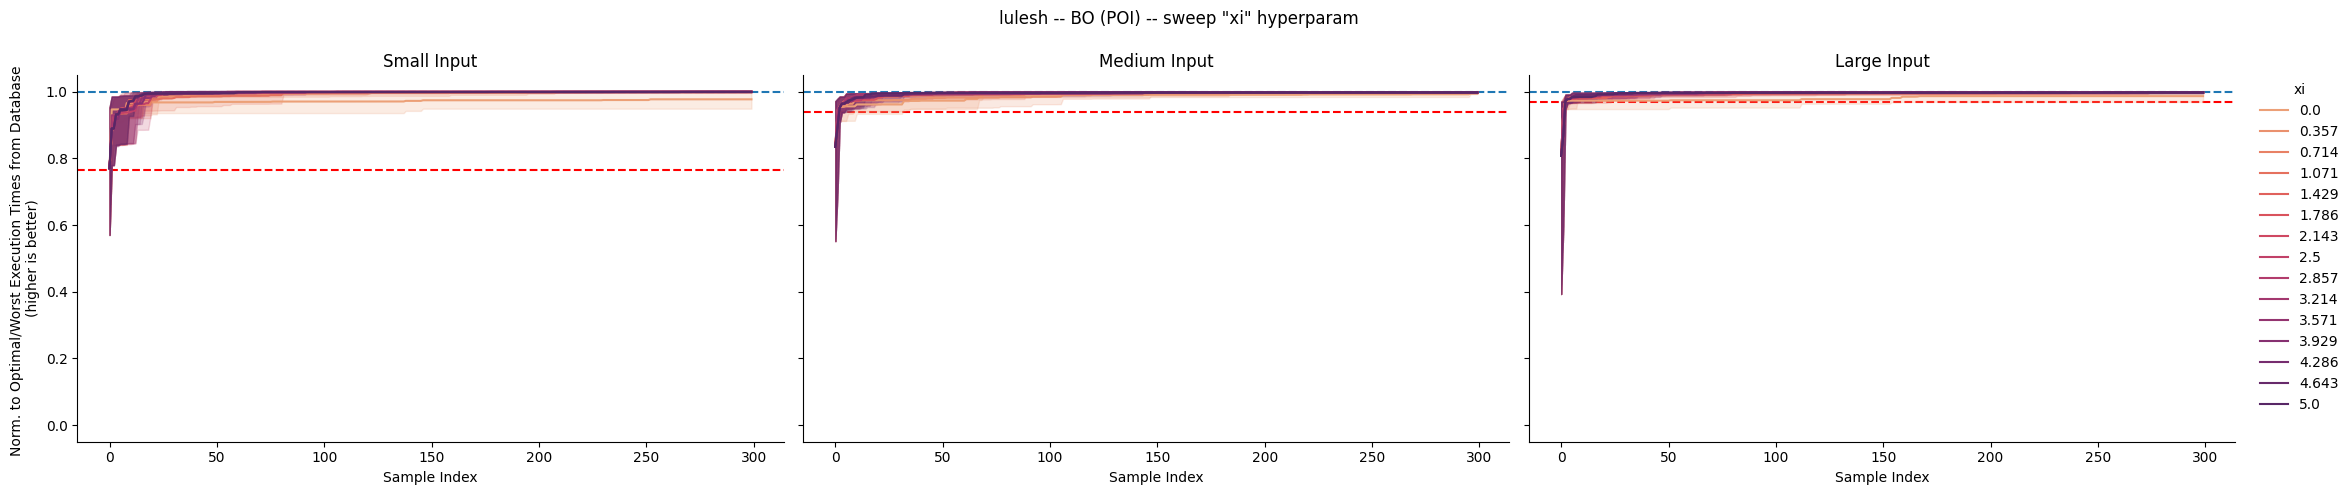

Index(['probsize', 'seed', 'globalSample', 'xtime', 'utilFnct', 'xi', 'kappa',
       'kappa_decay', 'kappa_decay_delay'],
      dtype='object')


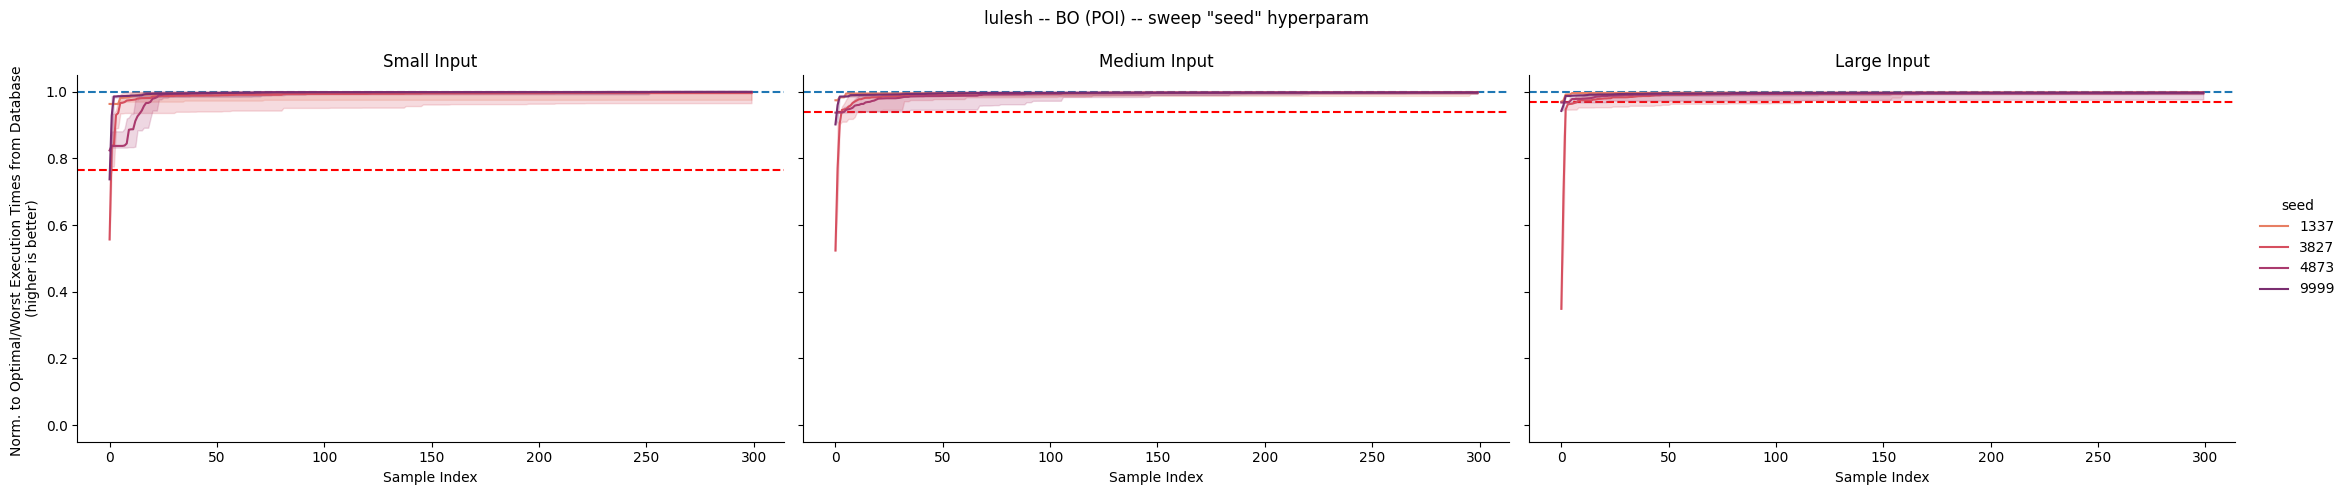

Index(['probsize', 'seed', 'globalSample', 'xtime', 'utilFnct', 'xi', 'kappa',
       'kappa_decay', 'kappa_decay_delay'],
      dtype='object')


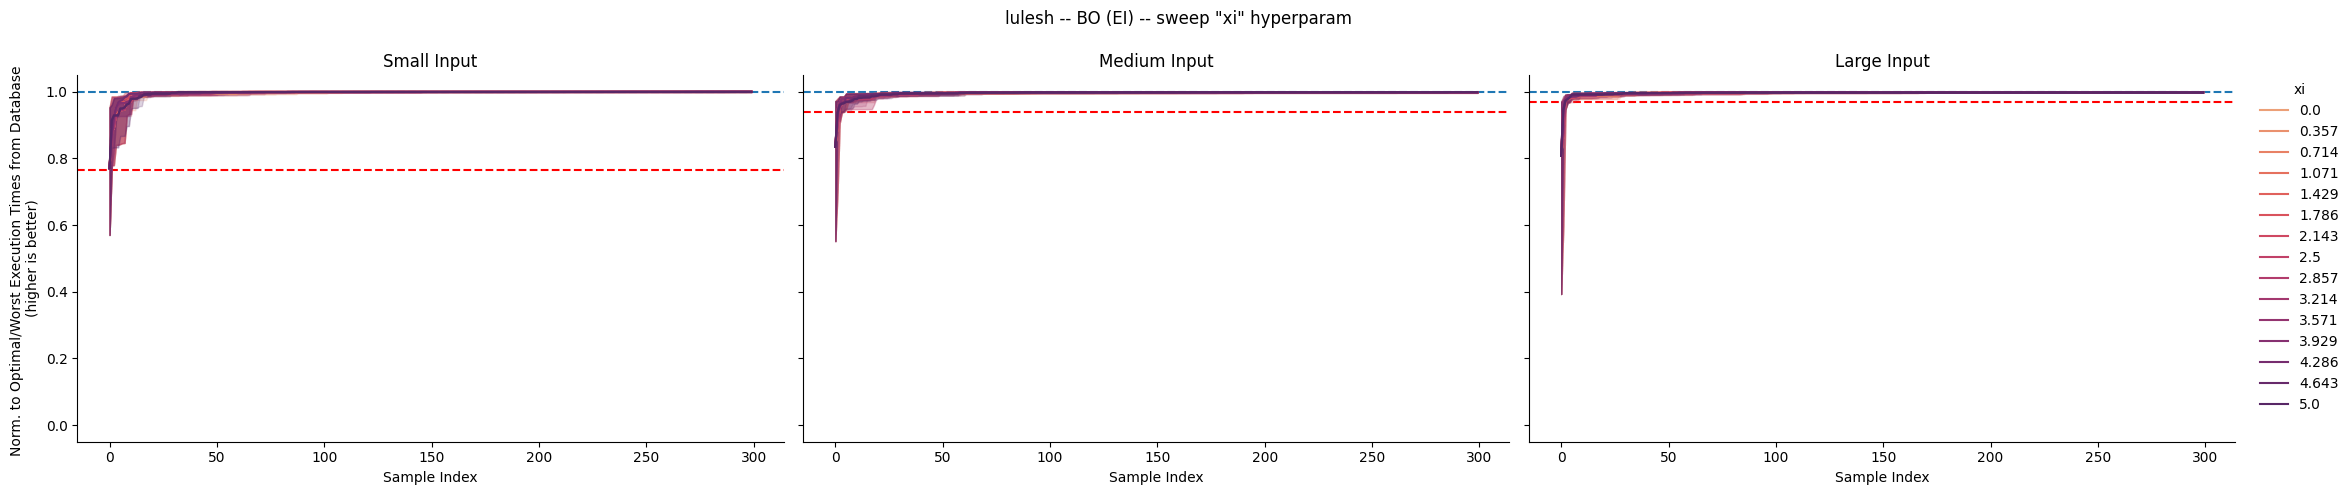

Index(['probsize', 'seed', 'globalSample', 'xtime', 'utilFnct', 'xi', 'kappa',
       'kappa_decay', 'kappa_decay_delay'],
      dtype='object')


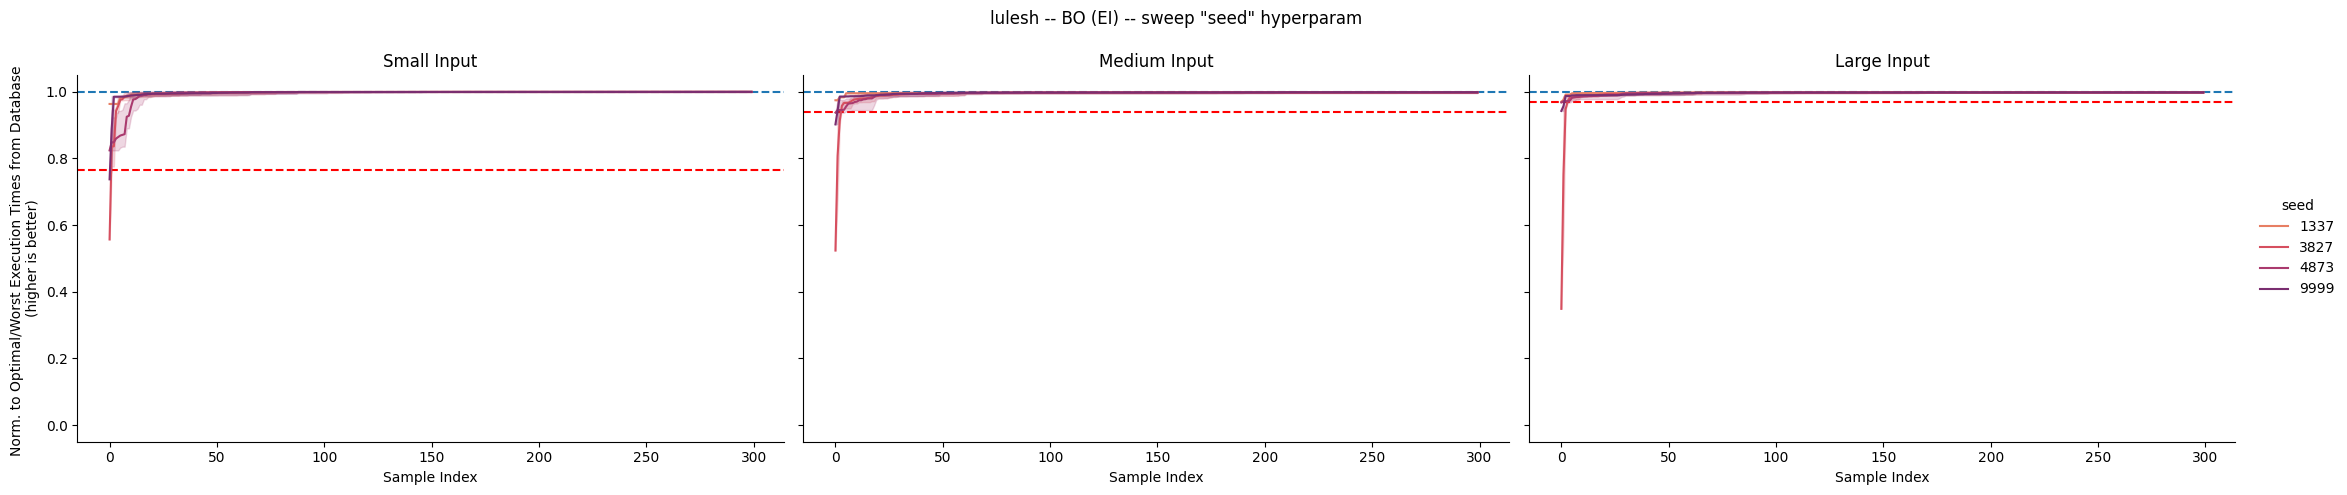

In [39]:
plotIndividualVariablesForAllCodes()